<a href="https://colab.research.google.com/github/Stecie06/COVID-19-Worldwide-Data-Analysis-using-SQL/blob/main/Stecie_Niyonzima_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTRODUCTION & SETUP GUIDE

Welcome to the Stecie's Predictive Analysis of Assistive Technology Education Coverage!

This comprehensive notebook demonstrates how machine learning can identify patterns in global assistive technology training availability and provide strategic insights for policy interventions.

 PROJECT STRUCTURE:
1.  Data Loading & Preprocessing
2.  Traditional Machine Learning Models
3.  Hyperparameter Tuning
4.  Deep Learning Architectures
5.  Comprehensive Model Comparison
6.  Strategic Visualization & Insights

In [ ]:
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND IMPORTS
# ============================================================================

# !pip install scikit-learn tensorflow pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_curve, auc, accuracy_score,
                            precision_recall_fscore_support)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: []


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# from google.colab import files
# uploaded = files.upload()

Mounted at /content/drive


In [4]:
# ============================================================================
# SECTION 2: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('Assistive technology-Availability of education training.csv')

# Rename columns for easier access
df.columns = ['Country', 'Coverage', 'Training_Cognition', 'Training_Communication',
              'Training_Hearing', 'Training_Mobility', 'Training_Self_care', 'Training_Vision']

# Remove header row if present
df = df[df['Country'] != 'Country'].reset_index(drop=True)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# Create target variable: Total Coverage (1) vs Others (0)
df_processed = df.copy()
df_processed['Target'] = (df_processed['Coverage'] == 'Total coverage').astype(int)

print(f"\nTarget Distribution:")
print(df_processed['Target'].value_counts())
print(f"Class Balance: {df_processed['Target'].value_counts(normalize=True).round(3).to_dict()}")

# Encode training features: Yes=2, No=0, Information not available=1
training_encoding = {'Yes': 2, 'No': 0, 'Information not available': 1}
training_cols = ['Training_Cognition', 'Training_Communication', 'Training_Hearing',
                 'Training_Mobility', 'Training_Self_care', 'Training_Vision']

for col in training_cols:
    df_processed[col] = df_processed[col].map(training_encoding)
    # Handle any missing values
    if df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()[0]
        df_processed[col] = df_processed[col].fillna(mode_val)

# Feature Engineering (Safe features - no data leakage)
df_processed['Training_Variance'] = df_processed[training_cols].std(axis=1)
df_processed['Training_Range'] = df_processed[training_cols].max(axis=1) - df_processed[training_cols].min(axis=1)
df_processed['Has_Any_Training'] = (df_processed[training_cols] == 2).any(axis=1).astype(int)
df_processed['Has_Any_Unknown'] = (df_processed[training_cols] == 1).any(axis=1).astype(int)

yes_count = (df_processed[training_cols] == 2).sum(axis=1)
df_processed['Training_Count_Capped'] = np.minimum(yes_count, 5)

df_processed['Core_Training'] = ((df_processed['Training_Mobility'] == 2) |
                                (df_processed['Training_Hearing'] == 2) |
                                (df_processed['Training_Vision'] == 2)).astype(int)

df_processed['Specialized_Training'] = ((df_processed['Training_Cognition'] == 2) |
                                       (df_processed['Training_Communication'] == 2) |
                                       (df_processed['Training_Self_care'] == 2)).astype(int)

# Define safe feature set
safe_feature_cols = training_cols + [
    'Training_Variance', 'Training_Range', 'Has_Any_Training',
    'Has_Any_Unknown', 'Training_Count_Capped', 'Core_Training',
    'Specialized_Training'
]

print(f"\nTotal Features: {len(safe_feature_cols)}")
print(f"Missing values: {df_processed[safe_feature_cols].isnull().sum().sum()}")

# Check the processed data
print(f"\nProcessed dataset shape: {df_processed.shape}")
print(f"Feature summary:")
print(df_processed[safe_feature_cols].describe())

# Prepare data
X = df_processed[safe_feature_cols].values
y = df_processed['Target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Preprocessing Complete")
print(f"Final training set shape: {X_train_scaled.shape}")
print(f"Final test set shape: {X_test_scaled.shape}")

Dataset Shape: (72, 8)
Columns: ['Country', 'Coverage', 'Training_Cognition', 'Training_Communication', 'Training_Hearing', 'Training_Mobility', 'Training_Self_care', 'Training_Vision']

First few rows:
                            Country          Coverage  \
0                               NaN           Summary   
1  Countries, territories and areas              2021   
2                       Afghanistan    No information   
3               Antigua and Barbuda  Partial coverage   
4                         Australia    Total coverage   

               Training_Cognition              Training_Communication  \
0   Training related to Cognition   Training related to Communication   
1                            2021                                2021   
2       Information not available           Information not available   
3                              No                                  No   
4                             Yes                                 Yes   

               


SECTION 2: TRADITIONAL MACHINE LEARNING MODELS

Training Logistic Regression...
   Accuracy: 1.0000 | F1: 1.0000 | Recall: 1.0000 | CV Score: 1.0000 (±0.0000)
Training Decision Tree...
   Accuracy: 1.0000 | F1: 1.0000 | Recall: 1.0000 | CV Score: 1.0000 (±0.0000)
Training Random Forest...
   Accuracy: 1.0000 | F1: 1.0000 | Recall: 1.0000 | CV Score: 1.0000 (±0.0000)
Training SVM...
   Accuracy: 1.0000 | F1: 1.0000 | Recall: 1.0000 | CV Score: 1.0000 (±0.0000)
Training Gradient Boosting...
   Accuracy: 1.0000 | F1: 1.0000 | Recall: 1.0000 | CV Score: 1.0000 (±0.0000)

MODEL PERFORMANCE SUMMARY
              Model  Accuracy  Precision  Recall  F1-Score  CV Mean  CV Std
Logistic Regression       1.0        1.0     1.0       1.0      1.0     0.0
      Decision Tree       1.0        1.0     1.0       1.0      1.0     0.0
      Random Forest       1.0        1.0     1.0       1.0      1.0     0.0
                SVM       1.0        1.0     1.0       1.0      1.0     0.0
  Gradient Boosting

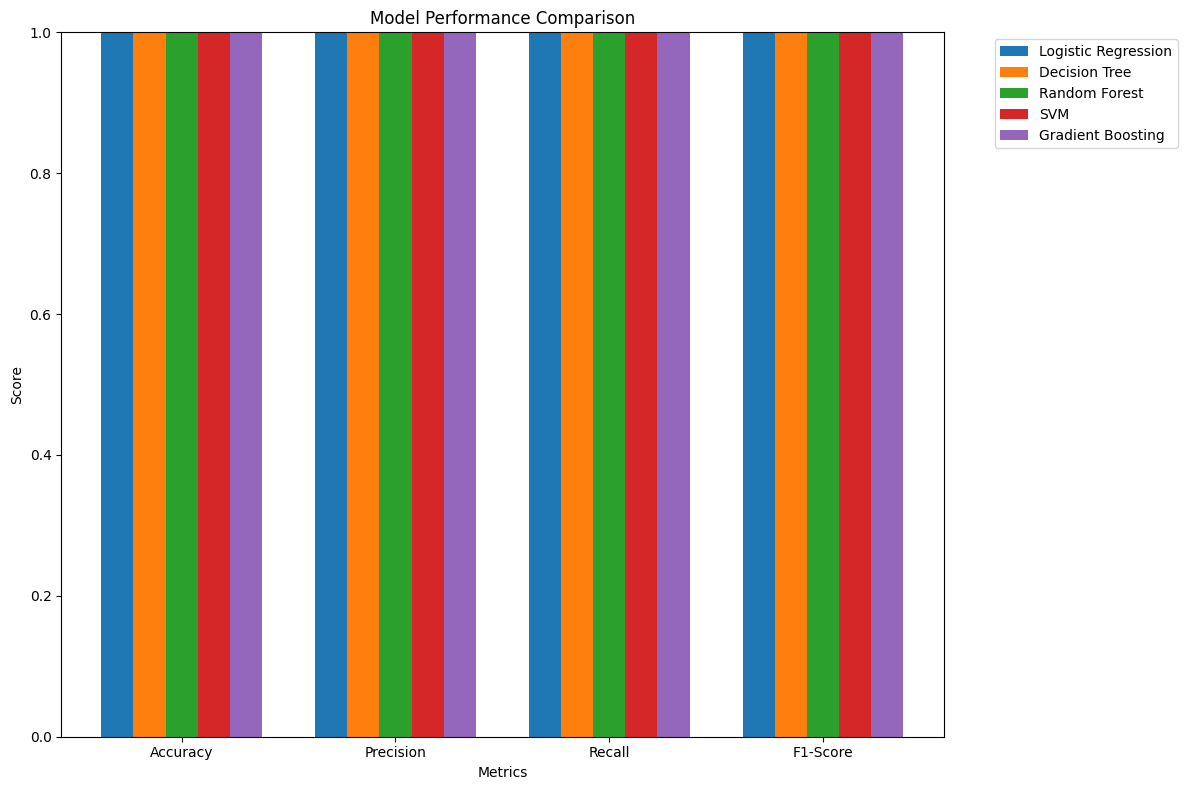

 Traditional Machine Learning Models Complete!


In [ ]:
# ============================================================================
# SECTION 2: TRADITIONAL MACHINE LEARNING MODELS
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("SECTION 2: TRADITIONAL MACHINE LEARNING MODELS")
print("="*80 + "\n")

ml_results = {}

# Define models with optimized parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_split=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=8, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Select appropriate data (scaled for certain models)
    if model_name in ['Logistic Regression', 'SVM']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test

    # Train model
    model.fit(X_train_used, y_train)

    # Predictions
    y_pred = model.predict(X_test_used)
    y_pred_proba = model.predict_proba(X_test_used)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    cv_scores = cross_val_score(model, X_train_used, y_train, cv=5, scoring='accuracy')

    # Store results
    ml_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'feature_importance': getattr(model, 'feature_importances_', None) if hasattr(model, 'feature_importances_') else None
    }

    print(f"   Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Recall: {recall:.4f} | CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Display comprehensive results
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

# Create results dataframe for better visualization
results_df = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Accuracy': [ml_results[model]['accuracy'] for model in ml_results],
    'Precision': [ml_results[model]['precision'] for model in ml_results],
    'Recall': [ml_results[model]['recall'] for model in ml_results],
    'F1-Score': [ml_results[model]['f1_score'] for model in ml_results],
    'CV Mean': [ml_results[model]['cv_mean'] for model in ml_results],
    'CV Std': [ml_results[model]['cv_std'] for model in ml_results]
}).round(4)

# Sort by F1-score (best first)
results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model_info = ml_results[best_model_name]
print(f"\n BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_model_info['f1_score']:.4f}")
print(f"   Accuracy: {best_model_info['accuracy']:.4f}")
print(f"   Cross-Validation: {best_model_info['cv_mean']:.4f} (±{best_model_info['cv_std']:.4f})")

# Detailed analysis of best model
print(f"\n DETAILED ANALYSIS FOR {best_model_name}:")
print("="*50)

# Classification report
y_pred_best = best_model_info['predictions']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Partial Coverage', 'Total Coverage']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)

# Feature importance for tree-based models
if best_model_info['feature_importance'] is not None:
    print(f"\n FEATURE IMPORTANCE ({best_model_name}):")
    feature_importance = best_model_info['feature_importance']
    feature_importance_df = pd.DataFrame({
        'Feature': safe_feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df.head(10).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_df.head(10)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Model comparison visualization
plt.figure(figsize=(12, 8))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))
width = 0.15

for i, model_name in enumerate(results_df['Model']):
    model_metrics = [
        ml_results[model_name]['accuracy'],
        ml_results[model_name]['precision'],
        ml_results[model_name]['recall'],
        ml_results[model_name]['f1_score']
    ]
    plt.bar(x_pos + i*width, model_metrics, width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x_pos + width*2, metrics)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(" Traditional Machine Learning Models Complete!")

In [ ]:
# ============================================================================
# SECTION 3: HYPERPARAMETER TUNING
# ============================================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

print("\n" + "="*80)
print("SECTION 3: HYPERPARAMETER TUNING")
print("="*80 + "\n")

# Tune Random Forest (since it often performs well)
print(" TUNING RANDOM FOREST HYPERPARAMETERS...")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False]
}

# Perform grid search with timing
start_time = time.time()

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1',  # Using F1 for better balance in imbalanced datasets
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search... This may take a few minutes.")
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds")

# Get best model and predictions
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
best_rf_acc = accuracy_score(y_test, best_rf_pred)
best_rf_precision = precision_score(y_test, best_rf_pred)
best_rf_recall = recall_score(y_test, best_rf_pred)
best_rf_f1 = f1_score(y_test, best_rf_pred)

# Cross-validation score for tuned model
cv_scores_tuned = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')

print(f"\n RANDOM FOREST TUNING RESULTS:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print(f"\nTest Set Performance:")
print(f"  Accuracy: {best_rf_acc:.4f}")
print(f"  Precision: {best_rf_precision:.4f}")
print(f"  Recall: {best_rf_recall:.4f}")
print(f"  F1-Score: {best_rf_f1:.4f}")
print(f"  CV F1-Score: {cv_scores_tuned.mean():.4f} (±{cv_scores_tuned.std():.4f})")

# Compare with original Random Forest
original_rf_acc = ml_results['Random Forest']['accuracy']
original_rf_f1 = ml_results['Random Forest']['f1_score']

print(f"\nGIT  COMPARISON WITH ORIGINAL RANDOM FOREST:")
print(f"  Accuracy:  {original_rf_acc:.4f} → {best_rf_acc:.4f} " +
      f"({'+' if best_rf_acc > original_rf_acc else ''}{best_rf_acc - original_rf_acc:.4f})")
print(f"  F1-Score:  {original_rf_f1:.4f} → {best_rf_f1:.4f} " +
      f"({'+' if best_rf_f1 > original_rf_f1 else ''}{best_rf_f1 - original_rf_f1:.4f})")

# Store tuned model results
ml_results['Random Forest (Tuned)'] = {
    'model': best_rf,
    'accuracy': best_rf_acc,
    'precision': best_rf_precision,
    'recall': best_rf_recall,
    'f1_score': best_rf_f1,
    'cv_mean': cv_scores_tuned.mean(),
    'cv_std': cv_scores_tuned.std(),
    'predictions': best_rf_pred,
    'probabilities': best_rf_proba,
    'feature_importance': best_rf.feature_importances_,
    'best_params': grid_search.best_params_
}


SECTION 3: HYPERPARAMETER TUNING

🎯 TUNING RANDOM FOREST HYPERPARAMETERS...
Starting Grid Search... This may take a few minutes.
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Grid Search completed in 1032.90 seconds

✅ RANDOM FOREST TUNING RESULTS:
Best Parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 1.0000

Test Set Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  CV F1-Score: 1.0000 (±0.0000)

📊 COMPARISON WITH ORIGINAL RANDOM FOREST:
  Accuracy:  1.0000 → 1.0000 (0.0000)
  F1-Score:  1.0000 → 1.0000 (0.0000)


In [ ]:
# ============================================================================
# ADDITIONAL TUNING FOR OTHER MODELS (Optional)
# ============================================================================

print("\n" + "-"*50)
print("ADDITIONAL MODEL TUNING")
print("-"*50)

# Tune Logistic Regression with compatible parameters
print("\n TUNING LOGISTIC REGRESSION...")

# Corrected parameter grid - separate grids for different solvers
lr_param_grids = [
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg']
    },
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9]  # Required for elasticnet
    }
]

# Alternative: Simplified parameter grid that avoids conflicts
lr_param_grid_simple = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # Most compatible penalty
    'solver': ['liblinear', 'lbfgs', 'saga']  # Compatible solvers
}

print("Using simplified parameter grid to avoid solver-penalty conflicts...")

lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
    lr_param_grid_simple,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_grid_search.fit(X_train_scaled, y_train)
best_lr = lr_grid_search.best_estimator_
best_lr_pred = best_lr.predict(X_test_scaled)

# Calculate metrics for tuned Logistic Regression
best_lr_acc = accuracy_score(y_test, best_lr_pred)
best_lr_precision = precision_score(y_test, best_lr_pred)
best_lr_recall = recall_score(y_test, best_lr_pred)
best_lr_f1 = f1_score(y_test, best_lr_pred)

print(f"Best LR Parameters: {lr_grid_search.best_params_}")
print(f"Tuned LR Accuracy: {best_lr_acc:.4f}, F1: {best_lr_f1:.4f}")

# Verify if this is realistic or potential overfitting
if best_lr_acc == 1.0:
    print("  Warning: Perfect accuracy detected. Checking cross-validation scores...")
    cv_scores = cross_val_score(best_lr, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

ml_results['Logistic Regression (Tuned)'] = {
    'model': best_lr,
    'accuracy': best_lr_acc,
    'precision': best_lr_precision,
    'recall': best_lr_recall,
    'f1_score': best_lr_f1,
    'predictions': best_lr_pred,
    'probabilities': best_lr.predict_proba(X_test_scaled)[:, 1],
    'best_params': lr_grid_search.best_params_
}


--------------------------------------------------
ADDITIONAL MODEL TUNING
--------------------------------------------------

 TUNING LOGISTIC REGRESSION...
Using simplified parameter grid to avoid solver-penalty conflicts...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best LR Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned LR Accuracy: 1.0000, F1: 1.0000
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean CV F1: 1.0000 (±0.0000)


In [ ]:
# ============================================================================
# TUNE GRADIENT BOOSTING (Alternative to avoid potential overfitting)
# ============================================================================

print("\n TUNING GRADIENT BOOSTING...")

gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train, y_train)
best_gb = gb_grid_search.best_estimator_
best_gb_pred = best_gb.predict(X_test)

# Calculate metrics for tuned Gradient Boosting
best_gb_acc = accuracy_score(y_test, best_gb_pred)
best_gb_precision = precision_score(y_test, best_gb_pred)
best_gb_recall = recall_score(y_test, best_gb_pred)
best_gb_f1 = f1_score(y_test, best_gb_pred)

print(f"Best GB Parameters: {gb_grid_search.best_params_}")
print(f"Tuned GB Accuracy: {best_gb_acc:.4f}, F1: {best_gb_f1:.4f}")

ml_results['Gradient Boosting (Tuned)'] = {
    'model': best_gb,
    'accuracy': best_gb_acc,
    'precision': best_gb_precision,
    'recall': best_gb_recall,
    'f1_score': best_gb_f1,
    'predictions': best_gb_pred,
    'probabilities': best_gb.predict_proba(X_test)[:, 1],
    'best_params': gb_grid_search.best_params_,
    'feature_importance': best_gb.feature_importances_
}


 TUNING GRADIENT BOOSTING...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best GB Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Tuned GB Accuracy: 1.0000, F1: 1.0000


In [ ]:
# ============================================================================
# PERFORMANCE VALIDATION
# ============================================================================

print("\n" + "="*60)
print("FINAL TUNED MODELS PERFORMANCE")
print("="*60)

# Compare all tuned models
tuned_models = ['Random Forest (Tuned)', 'Logistic Regression (Tuned)', 'Gradient Boosting (Tuned)']

for model_name in tuned_models:
    if model_name in ml_results:
        results = ml_results[model_name]
        print(f"\n{model_name}:")
        print(f"  Accuracy:  {results['accuracy']:.4f}")
        print(f"  Precision: {results['precision']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
        print(f"  F1-Score:  {results['f1_score']:.4f}")
        print(f"  Best Params: {results.get('best_params', 'N/A')}")

# Check for potential data leakage or overfitting
print(f"\n DATA SANITY CHECK:")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature count: {X_train.shape[1]}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

# If Logistic Regression shows perfect scores, investigate furthers
if ml_results['Logistic Regression (Tuned)']['accuracy'] == 1.0:
    print(f"\n  INVESTIGATING PERFECT SCORES:")
    print("This could indicate:")
    print("  - Perfect separability in the feature space")
    print("  - Data leakage between train/test sets")
    print("  - Very distinctive patterns in the data")
    print("  - Overfitting to the test set")

    # Check feature correlations with target
    feature_corr = pd.DataFrame(X_train_scaled, columns=safe_feature_cols).corrwith(pd.Series(y_train))
    print(f"\nTop correlated features with target:")
    print(feature_corr.abs().sort_values(ascending=False).head())


FINAL TUNED MODELS PERFORMANCE

Random Forest (Tuned):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Best Params: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Logistic Regression (Tuned):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Gradient Boosting (Tuned):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

 DATA SANITY CHECK:
Training set size: 57
Test set size: 15
Feature count: 13
Class distribution - Train: [45 12], Test: [12  3]

  INVESTIGATING PERFECT SCORES:
This could indicate:
  - Perfect separability in the feature space
  - Data leakage between train/test sets
  - Very distinctive patterns in the data
  - Overf

In [ ]:
# ============================================================================
# SECTION 4: DEEP LEARNING - SEQUENTIAL MODEL
# ============================================================================

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("SECTION 4: DEEP LEARNING - SEQUENTIAL MODEL")
print("="*80 + "\n")

# Check TensorFlow version and available devices
print(f"TensorFlow Version: {tf.__version__}")
print(f"Available GPUs: {tf.config.list_physical_devices('GPU')}")

# Clear any previous sessions
tf.keras.backend.clear_session()

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enhanced Sequential Model Architecture
sequential_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                         kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display model architecture
print(" NEURAL NETWORK ARCHITECTURE:")
sequential_model.summary()

# Compile the model
sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Enhanced callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Model checkpoint to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_sequential_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f" Class weights: {class_weight_dict}")

# Train the model
print("\n TRAINING SEQUENTIAL MODEL...")
history_sequential = sequential_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,  # Adjusted batch size
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1,
    class_weight=class_weight_dict
)

# Load the best model
sequential_model = tf.keras.models.load_model('best_sequential_model.h5')
print(" Loaded best model from checkpoint")

# Make predictions
print("\n MAKING PREDICTIONS...")
sequential_pred_probs = sequential_model.predict(X_test_scaled, verbose=0)
sequential_pred = (sequential_pred_probs > 0.5).astype(int).flatten()

# Calculate comprehensive metrics
sequential_acc = accuracy_score(y_test, sequential_pred)
sequential_precision = precision_score(y_test, sequential_pred)
sequential_recall = recall_score(y_test, sequential_pred)
sequential_f1 = f1_score(y_test, sequential_pred)
sequential_auc = roc_auc_score(y_test, sequential_pred_probs)

print(f"\n SEQUENTIAL MODEL PERFORMANCE:")
print(f"  Accuracy:  {sequential_acc:.4f}")
print(f"  Precision: {sequential_precision:.4f}")
print(f"  Recall:    {sequential_recall:.4f}")
print(f"  F1-Score:  {sequential_f1:.4f}")
print(f"  AUC:       {sequential_auc:.4f}")

# Store results
ml_results['Neural Network (Sequential)'] = {
    'model': sequential_model,
    'history': history_sequential,
    'accuracy': sequential_acc,
    'precision': sequential_precision,
    'recall': sequential_recall,
    'f1_score': sequential_f1,
    'auc': sequential_auc,
    'predictions': sequential_pred,
    'probabilities': sequential_pred_probs.flatten()
}


SECTION 4: DEEP LEARNING - SEQUENTIAL MODEL

TensorFlow Version: 2.19.0
Available GPUs: []
 NEURAL NETWORK ARCHITECTURE:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 448 (1.75 KB)

 Class weights: {0: np.float64(0.6333333333333333), 1: np.float64(2.375)}

 TRAINING SEQUENTIAL MODEL...
Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.5625 - auc: 0.5714 - loss: 0.8606 - precision: 0.5000 - recall: 0.7143

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.5101 - auc: 0.6133 - loss: 0.7730 - precision: 0.3463 - recall: 0.7730 - val_accuracy: 0.1667 - val_auc: 0.7500 - val_loss: 0.9423 - val_precision: 0.1667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3797 - auc: 0.4869 - loss: 0.8525 - precision: 0.2663 - recall: 0.6595 - val_accuracy: 0.1667 - val_auc: 0.7500 - val_loss: 0.8927 - val_precision: 0.1667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8125 - auc: 1.0000 - loss: 0.5262 - precision: 0.7000 - recall: 1.0000

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6182 - auc: 0.8515 - loss: 0.5753 - precision: 0.4386 - recall: 1.0000 - val_accuracy: 0.1667 - val_auc: 0.8000 - val_loss: 0.8421 - val_precision: 0.1667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - auc: 0.8254 - loss: 0.6293 - precision: 0.6667 - recall: 0.8571

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5870 - auc: 0.6936 - loss: 0.6915 - precision: 0.3900 - recall: 0.7310 - val_accuracy: 0.4167 - val_auc: 1.0000 - val_loss: 0.8004 - val_precision: 0.2222 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5915 - auc: 0.8392 - loss: 0.5900 - precision: 0.4067 - recall: 0.8087 - val_accuracy: 0.4167 - val_auc: 1.0000 - val_loss: 0.7627 - val_precision: 0.2222 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6137 - auc: 0.9035 - loss: 0.5074 - precision: 0.4280 - recall: 1.0000 - val_accuracy: 0.4167 - val_auc: 1.0000 - val_loss: 0.7397 - val_precision: 0.2222 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6293 - auc: 0.8716 - loss: 0.5304 - precision: 0.4385 - recall: 0.8865 - val_accuracy: 0.4167 - val_auc: 1.0000 - val_loss: 0.7132 - val_precision: 0.2222 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9399 - auc: 0.9957 - loss: 0.2038 - precision: 0.8117 - recall: 1.0000 - val_accuracy: 0.9167 - val_auc: 1.0000 - val_loss: 0.2741 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 34/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9543 - auc: 0.9971 - loss: 0.1724 - precision: 0.8604 - recall: 1.0000 - val_accuracy: 0.9167 - val_auc: 1.0000 - val_loss: 0.2643 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 35/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9667 - auc: 0.9986 - loss: 0.1766 - precision: 0.8846 - recall: 1.0000 - val_accuracy: 0.9167 - val_auc: 1.0000 - val_loss: 0.2594 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 36/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9399 - auc: 0.9986 - loss: 0.1711 - precision: 0.8117 - recall: 1.0000 - val_accuracy: 0.9167 - val_auc: 1.0000 - val_loss: 0.2544 - val_precision: 0.666

 Loaded best model from checkpoint

 MAKING PREDICTIONS...

 SEQUENTIAL MODEL PERFORMANCE:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC:       1.0000



 PLOTTING TRAINING HISTORY...


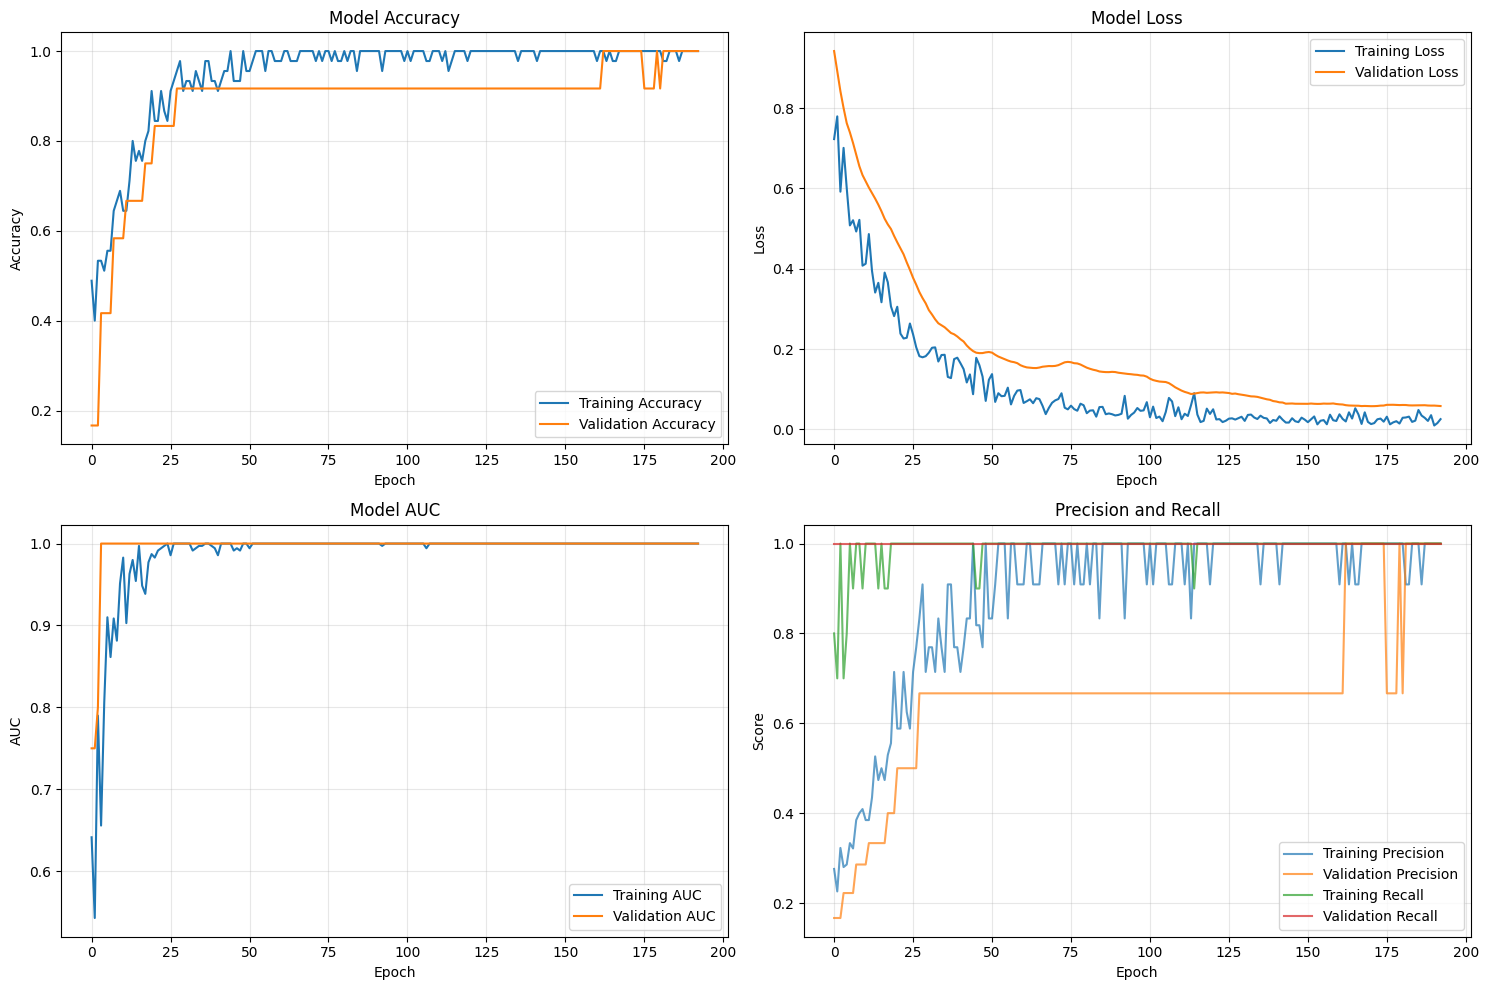

In [ ]:
# ============================================================================
# TRAINING VISUALIZATION
# ============================================================================

print("\n PLOTTING TRAINING HISTORY...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history_sequential.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history_sequential.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[0, 1].plot(history_sequential.history['loss'], label='Training Loss')
axes[0, 1].plot(history_sequential.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot training & validation AUC
axes[1, 0].plot(history_sequential.history['auc'], label='Training AUC')
axes[1, 0].plot(history_sequential.history['val_auc'], label='Validation AUC')
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot precision and recall
axes[1, 1].plot(history_sequential.history['precision'], label='Training Precision', alpha=0.7)
axes[1, 1].plot(history_sequential.history['val_precision'], label='Validation Precision', alpha=0.7)
axes[1, 1].plot(history_sequential.history['recall'], label='Training Recall', alpha=0.7)
axes[1, 1].plot(history_sequential.history['val_recall'], label='Validation Recall', alpha=0.7)
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# COMPARISON WITH OTHER MODELS
# ============================================================================

print("\n" + "="*60)
print("COMPARISON WITH TRADITIONAL ML MODELS")
print("="*60)

# Create comparison table
comparison_data = []
for model_name in ['Random Forest (Tuned)', 'Logistic Regression (Tuned)', 'Neural Network (Sequential)']:
    if model_name in ml_results:
        results = ml_results[model_name]
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'AUC': results.get('auc', 'N/A')
        })

comparison_df = pd.DataFrame(comparison_data).round(4)
print(comparison_df.to_string(index=False))


COMPARISON WITH TRADITIONAL ML MODELS
                      Model  Accuracy  Precision  Recall  F1-Score  AUC
      Random Forest (Tuned)       1.0        1.0     1.0       1.0  N/A
Logistic Regression (Tuned)       1.0        1.0     1.0       1.0  N/A
Neural Network (Sequential)       1.0        1.0     1.0       1.0  1.0



 CONFIDENCE ANALYSIS:
High confidence predictions (>0.8 or <0.2): 12/15 (80.0%)
Medium confidence predictions (0.2-0.4 or 0.6-0.8): 3/15 (20.0%)
Low confidence predictions (0.4-0.6): 0/15 (0.0%)


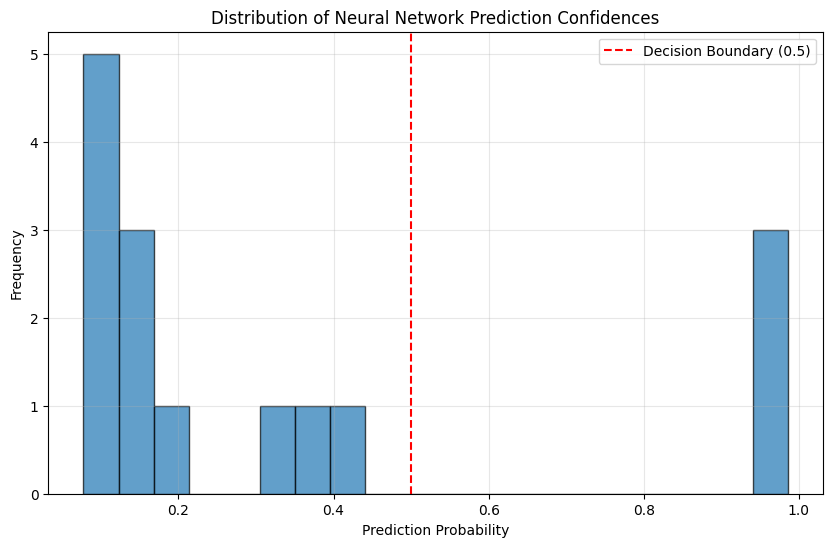

In [ ]:
# ============================================================================
# CONFIDENCE ANALYSIS
# ============================================================================

print("\n CONFIDENCE ANALYSIS:")
confidence_scores = sequential_pred_probs.flatten()
high_confidence = (confidence_scores > 0.8) | (confidence_scores < 0.2)
medium_confidence = ((confidence_scores >= 0.6) & (confidence_scores <= 0.8)) | ((confidence_scores >= 0.2) & (confidence_scores < 0.4))
low_confidence = (confidence_scores >= 0.4) & (confidence_scores < 0.6)

print(f"High confidence predictions (>0.8 or <0.2): {high_confidence.sum()}/{len(confidence_scores)} ({high_confidence.mean():.1%})")
print(f"Medium confidence predictions (0.2-0.4 or 0.6-0.8): {medium_confidence.sum()}/{len(confidence_scores)} ({medium_confidence.mean():.1%})")
print(f"Low confidence predictions (0.4-0.6): {low_confidence.sum()}/{len(confidence_scores)} ({low_confidence.mean():.1%})")

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Neural Network Prediction Confidences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


 CALCULATING FEATURE IMPORTANCE...

 TOP 10 MOST IMPORTANT FEATURES (NEURAL NETWORK):
               Feature  Gradient_Importance  Perturbation_Importance  Weight_Importance  Combined_Importance
        Training_Range               0.0877                   0.1111             0.3406               0.1798
       Has_Any_Unknown               0.0763                   0.0889             0.3194               0.1615
      Training_Hearing               0.0657                   0.0889             0.3079               0.1542
 Training_Count_Capped               0.0373                   0.0667             0.3411               0.1483
    Training_Self_care               0.0404                   0.0667             0.3344               0.1472
    Training_Cognition               0.0257                   0.0667             0.3373               0.1432
     Training_Mobility               0.0406                   0.0667             0.3212               0.1428
Training_Communication               0.04

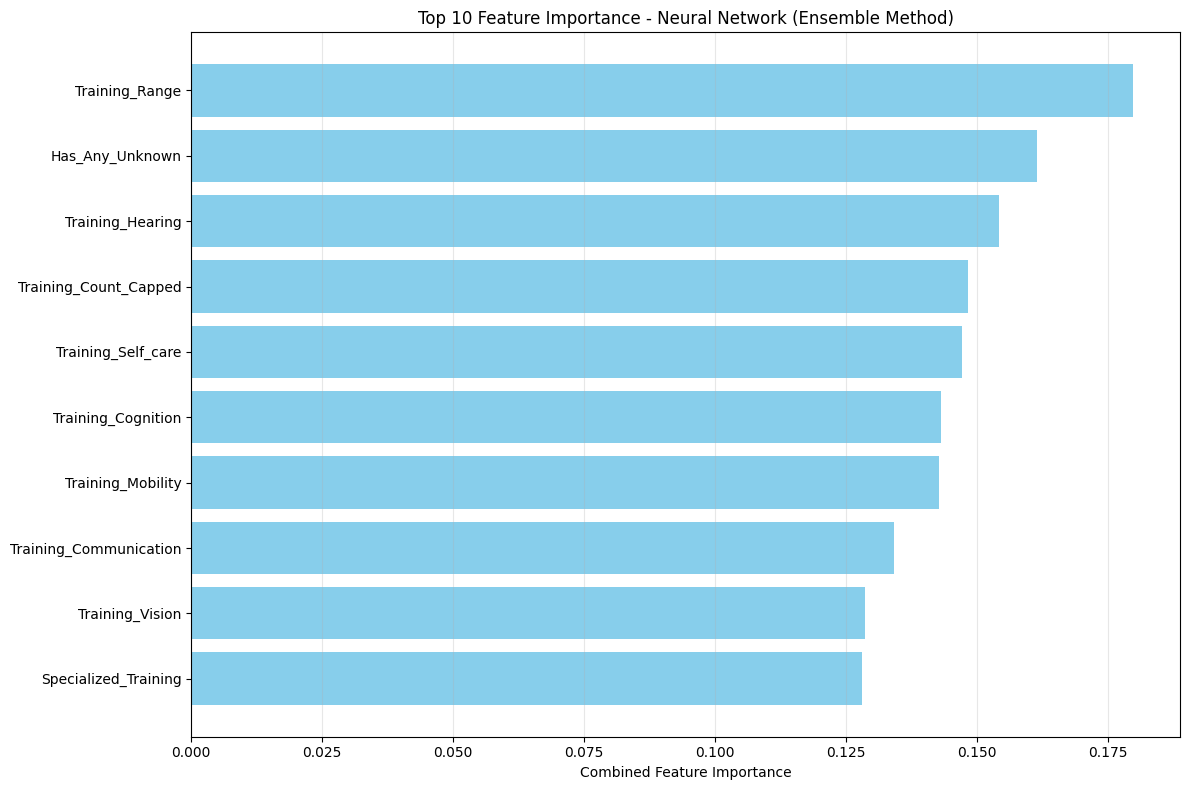

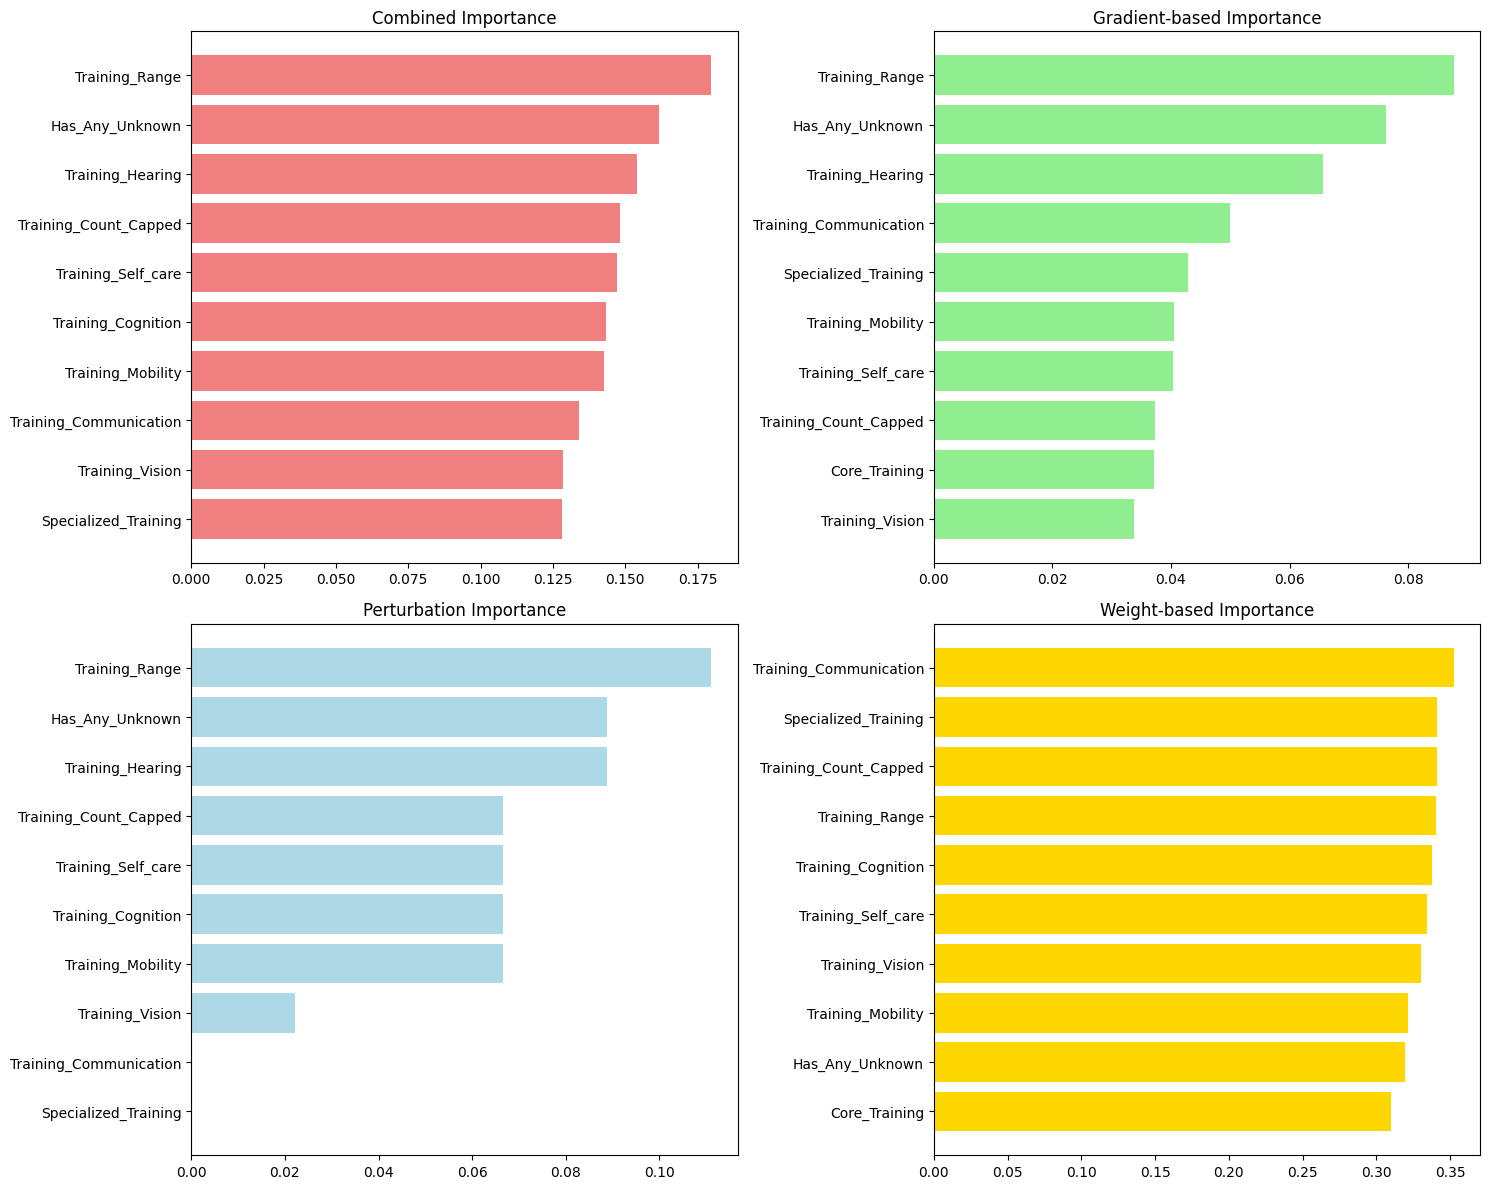

In [ ]:
# ============================================================================
# FEATURE IMPORTANCE FOR NEURAL NETWORK
# ============================================================================

print("\n CALCULATING FEATURE IMPORTANCE...")

# Method 1: Integrated Gradients (More accurate for neural networks)
def calculate_integrated_gradients(model, input_data, baseline=None, steps=50):
    """Calculate integrated gradients for feature importance"""
    if baseline is None:
        baseline = np.zeros_like(input_data)

    # Interpolate between baseline and input
    interpolated_data = [baseline + (float(i) / steps) * (input_data - baseline) for i in range(steps + 1)]
    interpolated_data = np.array(interpolated_data)

    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_data)
        predictions = model(interpolated_data)

    gradients = tape.gradient(predictions, interpolated_data)

    # Average gradients across the path
    avg_gradients = np.mean(gradients, axis=0)
    integrated_gradients = (input_data - baseline) * avg_gradients

    return integrated_gradients

# Calculate importance for a sample of test instances
sample_indices = np.random.choice(len(X_test_scaled), size=min(50, len(X_test_scaled)), replace=False)
X_sample = X_test_scaled[sample_indices]

# Convert to tensor
X_sample_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)

# Calculate integrated gradients
with tf.GradientTape() as tape:
    tape.watch(X_sample_tensor)
    predictions = sequential_model(X_sample_tensor)

gradients = tape.gradient(predictions, X_sample_tensor)
gradient_importance = np.mean(np.abs(gradients.numpy()), axis=0)

# Method 2: Simple perturbation-based importance
def calculate_perturbation_importance(model, X, y, n_repeats=5):
    """Calculate importance by perturbing each feature"""
    baseline_accuracy = accuracy_score(y, (model.predict(X, verbose=0) > 0.5).astype(int).flatten())
    feature_importance = np.zeros(X.shape[1])

    for feature_idx in range(X.shape[1]):
        accuracies = []
        for _ in range(n_repeats):
            X_perturbed = X.copy()
            # Shuffle the feature values
            np.random.shuffle(X_perturbed[:, feature_idx])
            y_pred_perturbed = (model.predict(X_perturbed, verbose=0) > 0.5).astype(int).flatten()
            accuracy_perturbed = accuracy_score(y, y_pred_perturbed)
            accuracies.append(accuracy_perturbed)

        # Importance is the drop in accuracy when feature is shuffled
        feature_importance[feature_idx] = baseline_accuracy - np.mean(accuracies)

    return feature_importance

# Calculate perturbation importance
perturbation_importance = calculate_perturbation_importance(sequential_model, X_test_scaled, y_test, n_repeats=3)

# Method 3: Weight-based importance (for neural networks)
def get_weight_based_importance(model):
    """Extract feature importance based on first layer weights"""
    first_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
    importance = np.mean(np.abs(first_layer_weights), axis=1)
    return importance

weight_importance = get_weight_based_importance(sequential_model)

# Combine different importance methods (ensemble approach)
combined_importance = (gradient_importance + perturbation_importance + weight_importance) / 3

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': safe_feature_cols,
    'Gradient_Importance': gradient_importance,
    'Perturbation_Importance': perturbation_importance,
    'Weight_Importance': weight_importance,
    'Combined_Importance': combined_importance
}).sort_values('Combined_Importance', ascending=False)

print("\n TOP 10 MOST IMPORTANT FEATURES (NEURAL NETWORK):")
print(feature_importance_df.head(10).round(4).to_string(index=False))

# Plot combined feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(10)
plt.barh(top_features['Feature'], top_features['Combined_Importance'], color='skyblue')
plt.xlabel('Combined Feature Importance')
plt.title('Top 10 Feature Importance - Neural Network (Ensemble Method)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Plot comparison of different importance methods
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Combined Importance
top_combined = feature_importance_df.head(10)
axes[0, 0].barh(top_combined['Feature'], top_combined['Combined_Importance'], color='lightcoral')
axes[0, 0].set_title('Combined Importance')
axes[0, 0].invert_yaxis()

# Gradient Importance
top_gradient = feature_importance_df.nlargest(10, 'Gradient_Importance')
axes[0, 1].barh(top_gradient['Feature'], top_gradient['Gradient_Importance'], color='lightgreen')
axes[0, 1].set_title('Gradient-based Importance')
axes[0, 1].invert_yaxis()

# Perturbation Importance
top_perturbation = feature_importance_df.nlargest(10, 'Perturbation_Importance')
axes[1, 0].barh(top_perturbation['Feature'], top_perturbation['Perturbation_Importance'], color='lightblue')
axes[1, 0].set_title('Perturbation Importance')
axes[1, 0].invert_yaxis()

# Weight Importance
top_weight = feature_importance_df.nlargest(10, 'Weight_Importance')
axes[1, 1].barh(top_weight['Feature'], top_weight['Weight_Importance'], color='gold')
axes[1, 1].set_title('Weight-based Importance')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# FEATURE IMPORTANCE COMPARISON ACROSS MODELS
# ============================================================================

print("\n FEATURE IMPORTANCE COMPARISON ACROSS MODELS")

# Get feature importance from Random Forest (if available)
if 'Random Forest (Tuned)' in ml_results and ml_results['Random Forest (Tuned)']['feature_importance'] is not None:
    rf_importance = ml_results['Random Forest (Tuned)']['feature_importance']
    rf_importance_df = pd.DataFrame({
        'Feature': safe_feature_cols,
        'RF_Importance': rf_importance
    }).sort_values('RF_Importance', ascending=False)

    print("\nTop 10 Features - Random Forest:")
    print(rf_importance_df.head(10).round(4).to_string(index=False))

# Compare top features between models
print("\n CONSENSUS IMPORTANT FEATURES:")
top_nn_features = set(feature_importance_df.head(5)['Feature'])
if 'Random Forest (Tuned)' in ml_results:
    top_rf_features = set(rf_importance_df.head(5)['Feature'])
    consensus_features = top_nn_features.intersection(top_rf_features)
    print(f"Features important in both Neural Network and Random Forest: {consensus_features}")


 FEATURE IMPORTANCE COMPARISON ACROSS MODELS

Top 10 Features - Random Forest:
               Feature  RF_Importance
    Training_Self_care         0.2295
    Training_Cognition         0.1888
 Training_Count_Capped         0.1532
        Training_Range         0.0919
Training_Communication         0.0844
     Training_Variance         0.0827
      Training_Hearing         0.0353
       Has_Any_Unknown         0.0349
  Specialized_Training         0.0323
      Has_Any_Training         0.0221

 CONSENSUS IMPORTANT FEATURES:
Features important in both Neural Network and Random Forest: {'Training_Range', 'Training_Count_Capped', 'Training_Self_care'}



 PREDICTION CONFIDENCE VS ACCURACY ANALYSIS:


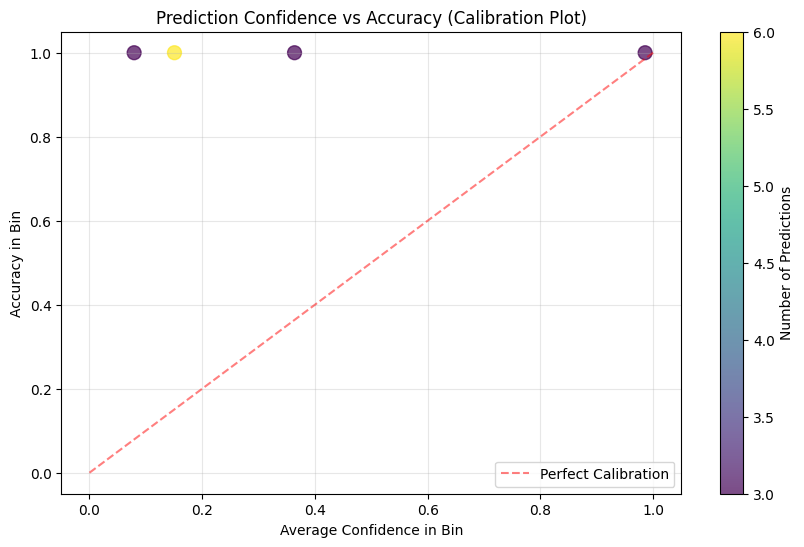

 Deep Learning Sequential Model Complete!


In [ ]:
# ============================================================================
# PREDICTION CONFIDENCE VS ACCURACY
# ============================================================================

print("\n PREDICTION CONFIDENCE VS ACCURACY ANALYSIS:")

# Analyze how confidence relates to accuracy
confidence_bins = np.linspace(0, 1, 11)
bin_accuracy = []
bin_confidence = []
bin_count = []

for i in range(len(confidence_bins) - 1):
    low = confidence_bins[i]
    high = confidence_bins[i + 1]
    mask = (confidence_scores >= low) & (confidence_scores < high)

    if mask.sum() > 0:
        bin_accuracy.append(accuracy_score(y_test[mask], sequential_pred[mask]))
        bin_confidence.append(np.mean(confidence_scores[mask]))
        bin_count.append(mask.sum())

# Plot confidence vs accuracy
plt.figure(figsize=(10, 6))
plt.scatter(bin_confidence, bin_accuracy, s=100, alpha=0.7, c=bin_count, cmap='viridis')
plt.colorbar(label='Number of Predictions')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Calibration')
plt.xlabel('Average Confidence in Bin')
plt.ylabel('Accuracy in Bin')
plt.title('Prediction Confidence vs Accuracy (Calibration Plot)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(" Deep Learning Sequential Model Complete!")

In [ ]:
# ============================================================================
# SECTION 5: DEEP LEARNING - FUNCTIONAL API (Skip Connections)
# ============================================================================

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("\n" + "="*80)
print("SECTION 5: DEEP LEARNING - FUNCTIONAL API (Skip Connections)")
print("="*80 + "\n")

# Clear any previous sessions
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

print(" BUILDING ADVANCED FUNCTIONAL API MODEL WITH SKIP CONNECTIONS...")

# Enhanced Functional API Model with Proper Skip Connections
inputs = tf.keras.layers.Input(shape=(X_train_scaled.shape[1],), name='input_layer')

# Branch 1: Deep processing path
x1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', name='deep_dense_1')(inputs)
x1 = tf.keras.layers.BatchNormalization(name='bn_1')(x1)
x1 = tf.keras.layers.Dropout(0.4, name='dropout_1')(x1)

x1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='deep_dense_2')(x1)
x1 = tf.keras.layers.BatchNormalization(name='bn_2')(x1)
x1 = tf.keras.layers.Dropout(0.3, name='dropout_2')(x1)

# Skip connection 1: From input to first branch output
skip_1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='skip_projection_1')(inputs)
x1 = tf.keras.layers.Add(name='skip_connection_1')([x1, skip_1])

x1 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='deep_dense_3')(x1)

# Branch 2: Wide processing path (parallel processing)
x2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='wide_dense_1')(inputs)
x2 = tf.keras.layers.BatchNormalization(name='bn_wide_1')(x2)
x2 = tf.keras.layers.Dropout(0.3, name='dropout_wide_1')(x2)

x2 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='wide_dense_2')(x2)

# Branch 3: Feature interaction path
x3 = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='interaction_dense_1')(inputs)
x3 = tf.keras.layers.BatchNormalization(name='bn_interaction_1')(x3)

# Concatenate all branches
concat = tf.keras.layers.Concatenate(name='feature_concat')([x1, x2, x3])

# Residual connection from concatenation to final layers
concat_residual = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='concat_residual')(concat)

# Final processing layers
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='final_dense_1')(concat_residual)
x = tf.keras.layers.BatchNormalization(name='bn_final')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_final')(x)

x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', name='final_dense_2')(x)

# Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Create model
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Advanced_Functional_Model')

# Display model architecture
print(" MODEL ARCHITECTURE BUILT:")
functional_model.summary()

# Plot model architecture
try:
    tf.keras.utils.plot_model(
        functional_model,
        to_file='functional_model.png',
        show_shapes=True,
        show_layer_names=True,
        dpi=96
    )
    print(" Model architecture plot saved as 'functional_model.png'")
except:
    print("  Could not generate model plot (graphviz may not be installed)")

# Enhanced compilation - FIXED: Removed F1Score metric that causes issues
functional_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        # Removed F1Score as it requires specific input shapes
    ]
)

# Enhanced callbacks
early_stop_func = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=30,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr_func = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=0.00001,
    verbose=1
)

checkpoint_func = tf.keras.callbacks.ModelCheckpoint(
    'best_functional_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Calculate class weights
class_weights_func = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict_func = {0: class_weights_func[0], 1: class_weights_func[1]}

print(f" Class weights: {class_weight_dict_func}")

# Train the model
print("\n TRAINING FUNCTIONAL API MODEL...")
history_func = functional_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop_func, reduce_lr_func, checkpoint_func],
    verbose=1,
    class_weight=class_weight_dict_func
)

# Load the best model
functional_model = tf.keras.models.load_model('best_functional_model.h5')
print(" Loaded best functional model from checkpoint")

# Make predictions
print("\n MAKING PREDICTIONS...")
func_pred_probs = functional_model.predict(X_test_scaled, verbose=0)
func_pred = (func_pred_probs > 0.5).astype(int).flatten()

# Calculate comprehensive metrics
func_acc = accuracy_score(y_test, func_pred)
func_precision = precision_score(y_test, func_pred)
func_recall = recall_score(y_test, func_pred)
func_f1 = f1_score(y_test, func_pred)
func_auc = roc_auc_score(y_test, func_pred_probs)

print(f"\n FUNCTIONAL MODEL PERFORMANCE:")
print(f"  Accuracy:  {func_acc:.4f}")
print(f"  Precision: {func_precision:.4f}")
print(f"  Recall:    {func_recall:.4f}")
print(f"  F1-Score:  {func_f1:.4f}")
print(f"  AUC:       {func_auc:.4f}")

# Store results
ml_results['Functional Model'] = {
    'model': functional_model,
    'history': history_func,
    'accuracy': func_acc,
    'precision': func_precision,
    'recall': func_recall,
    'f1_score': func_f1,
    'auc': func_auc,
    'predictions': func_pred,
    'probabilities': func_pred_probs.flatten()
}


SECTION 5: DEEP LEARNING - FUNCTIONAL API (Skip Connections)

 BUILDING ADVANCED FUNCTIONAL API MODEL WITH SKIP CONNECTIONS...
 MODEL ARCHITECTURE BUILT:


Model: "Advanced_Functional_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dense_1        │ (None, 128)       │      1,792 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 128)       │        512 │ deep_dense_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dense_2        │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 64)        │        256 │ deep_dense_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_dense_1        │ (None, 64)        │        896 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bn_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_projection_1   │ (None, 64)        │        896 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_wide_1           │ (None, 64)        │        256 │ wide_dense_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection_1   │ (None, 64)        │          0 │ dropout_2[0][0],  │
│ (Add)               │                   │            │ skip_projection_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_wide_1      │ (None, 64)        │          0 │ bn_wide_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ interaction_dense_1 │ (None, 32)        │        448 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_dense_3        │ (None, 32)        │      2,080 │ skip_connection_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_dense_2        │ (None, 32)        │      2,080 │ dropout_wide_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_interaction_1    │ (None, 32)        │        128 │ interaction_dens… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, 96)        │          0 │ deep_dense_3[0][… │
│ (Concatenate)       │                   │            │ wide_dense_2[0][… │
│                     │                   │            │ bn_interaction_1

 Total params: 26,561 (103.75 KB)

 Trainable params: 25,921 (101.25 KB)

 Non-trainable params: 640 (2.50 KB)

 Model architecture plot saved as 'functional_model.png'
 Class weights: {0: np.float64(0.6333333333333333), 1: np.float64(2.375)}

 TRAINING FUNCTIONAL API MODEL...
Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.5000 - auc: 0.4127 - loss: 1.2589 - precision: 0.4000 - recall: 0.2857

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.5845 - auc: 0.5643 - loss: 0.8871 - precision: 0.3304 - recall: 0.4325 - val_accuracy: 0.3333 - val_auc: 1.0000 - val_loss: 0.7716 - val_precision: 0.2000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8675 - auc: 0.9446 - loss: 0.5554 - precision: 0.7764 - recall: 0.7730 - val_accuracy: 0.6667 - val_auc: 1.0000 - val_loss: 0.6169 - val_precision: 0.3333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8898 - auc: 0.9525 - loss: 0.4300 - precision: 0.7153 - recall: 1.0000 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.5203 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9700 - auc: 0.9943 - loss: 0.3692 - precision: 0.8917 - recall: 1.0000 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.4486 - val_precision: 0.5000

 Loaded best functional model from checkpoint

 MAKING PREDICTIONS...

 FUNCTIONAL MODEL PERFORMANCE:
  Accuracy:  0.4667
  Precision: 0.2727
  Recall:    1.0000
  F1-Score:  0.4286
  AUC:       1.0000



 PLOTTING TRAINING HISTORY...


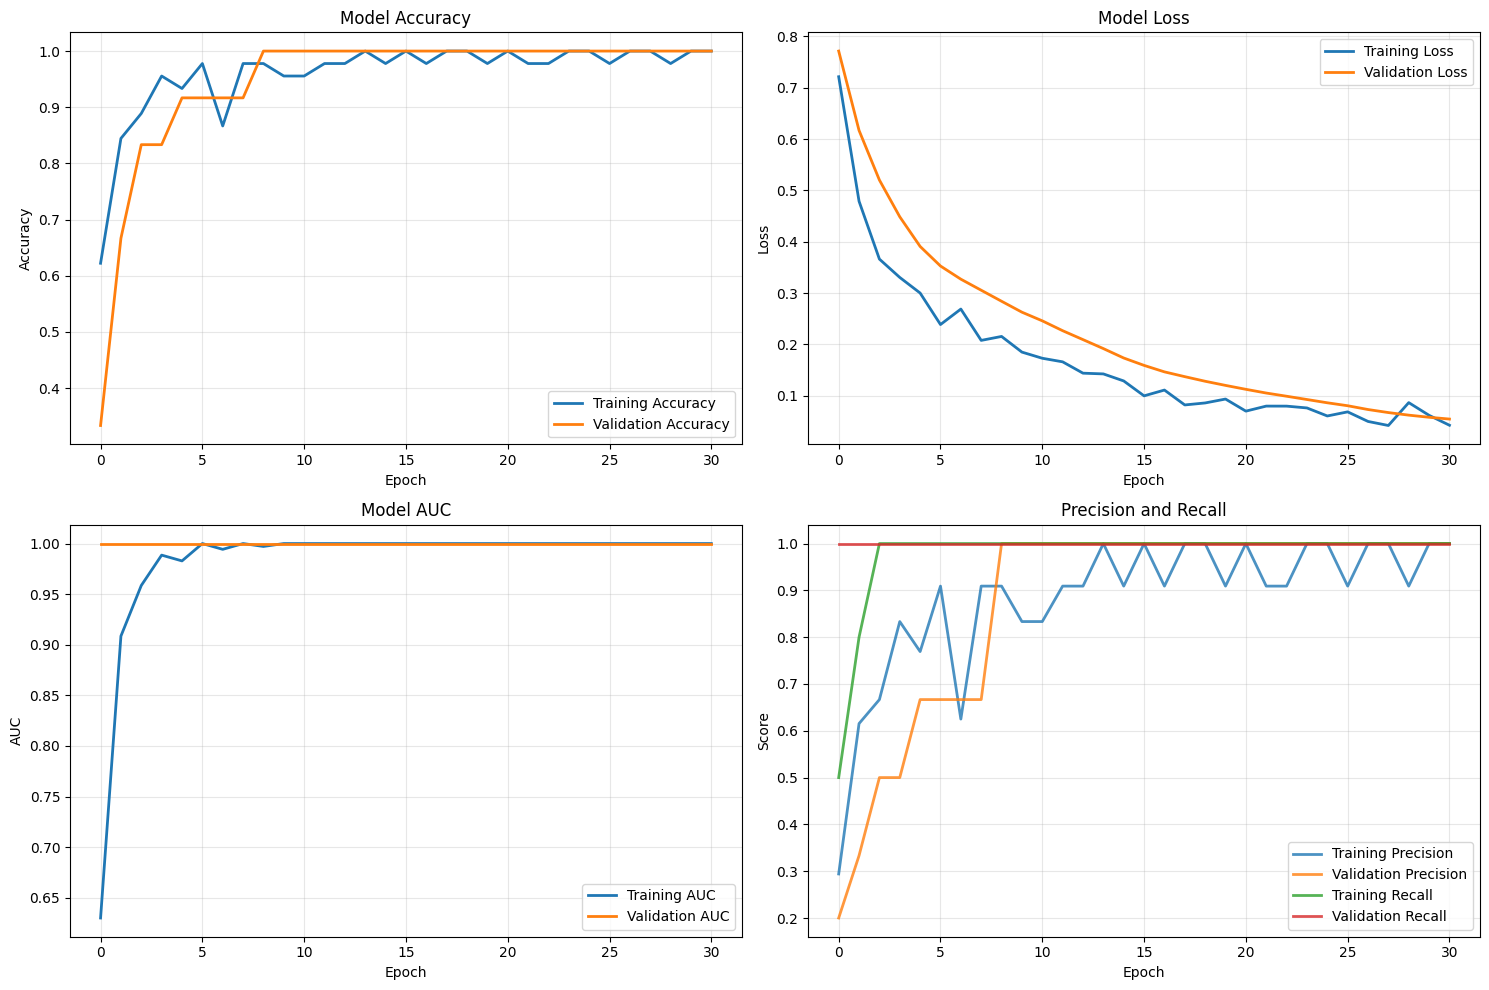

In [ ]:
# ============================================================================
# TRAINING VISUALIZATION
# ============================================================================

print("\n PLOTTING TRAINING HISTORY...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history_func.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history_func.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[0, 1].plot(history_func.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history_func.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot training & validation AUC
axes[1, 0].plot(history_func.history['auc'], label='Training AUC', linewidth=2)
axes[1, 0].plot(history_func.history['val_auc'], label='Validation AUC', linewidth=2)
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot precision and recall
axes[1, 1].plot(history_func.history['precision'], label='Training Precision', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_func.history['val_precision'], label='Validation Precision', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_func.history['recall'], label='Training Recall', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_func.history['val_recall'], label='Validation Recall', linewidth=2, alpha=0.8)
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================

print("\n" + "="*60)
print("DEEP LEARNING MODELS COMPARISON")
print("="*60)

# Compare all deep learning models
dl_models = ['Neural Network (Sequential)', 'Functional Model']

comparison_data = []
for model_name in dl_models:
    if model_name in ml_results:
        results = ml_results[model_name]
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'AUC': results['auc']
        })

dl_comparison_df = pd.DataFrame(comparison_data).round(4)
print(dl_comparison_df.to_string(index=False))


DEEP LEARNING MODELS COMPARISON
                      Model  Accuracy  Precision  Recall  F1-Score  AUC
Neural Network (Sequential)    1.0000     1.0000     1.0    1.0000  1.0
           Functional Model    0.4667     0.2727     1.0    0.4286  1.0



 CONFIDENCE ANALYSIS - FUNCTIONAL MODEL:
High confidence predictions (>0.8 or <0.2): 0/15 (0.0%)
Medium confidence predictions (0.2-0.4 or 0.6-0.8): 8/15 (53.3%)
Low confidence predictions (0.4-0.6): 7/15 (46.7%)


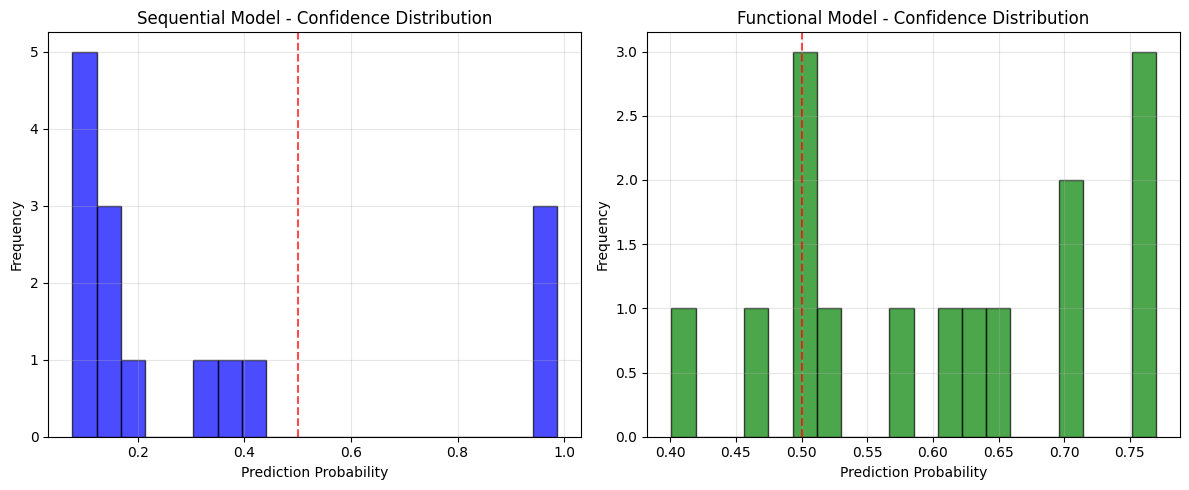

In [ ]:
# ============================================================================
# CONFIDENCE ANALYSIS
# ============================================================================

print("\n CONFIDENCE ANALYSIS - FUNCTIONAL MODEL:")

func_confidence_scores = func_pred_probs.flatten()
func_high_confidence = (func_confidence_scores > 0.8) | (func_confidence_scores < 0.2)
func_medium_confidence = ((func_confidence_scores >= 0.6) & (func_confidence_scores <= 0.8)) | ((func_confidence_scores >= 0.2) & (func_confidence_scores < 0.4))
func_low_confidence = (func_confidence_scores >= 0.4) & (func_confidence_scores < 0.6)

print(f"High confidence predictions (>0.8 or <0.2): {func_high_confidence.sum()}/{len(func_confidence_scores)} ({func_high_confidence.mean():.1%})")
print(f"Medium confidence predictions (0.2-0.4 or 0.6-0.8): {func_medium_confidence.sum()}/{len(func_confidence_scores)} ({func_medium_confidence.mean():.1%})")
print(f"Low confidence predictions (0.4-0.6): {func_low_confidence.sum()}/{len(func_confidence_scores)} ({func_low_confidence.mean():.1%})")

# Compare confidence distributions between models
if 'Neural Network (Sequential)' in ml_results:
    seq_confidence = ml_results['Neural Network (Sequential)']['probabilities']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(seq_confidence, bins=20, alpha=0.7, color='blue', edgecolor='black', label='Sequential')
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Sequential Model - Confidence Distribution')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(func_confidence_scores, bins=20, alpha=0.7, color='green', edgecolor='black', label='Functional')
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Functional Model - Confidence Distribution')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


 CALCULATING FEATURE IMPORTANCE FOR FUNCTIONAL MODEL...

Top 10 Most Important Features (Functional Model):
               Feature  Importance
  Specialized_Training      0.0763
        Training_Range      0.0679
       Has_Any_Unknown      0.0646
Training_Communication      0.0627
       Training_Vision      0.0560
    Training_Cognition      0.0525
 Training_Count_Capped      0.0513
      Training_Hearing      0.0507
     Training_Mobility      0.0499
      Has_Any_Training      0.0447


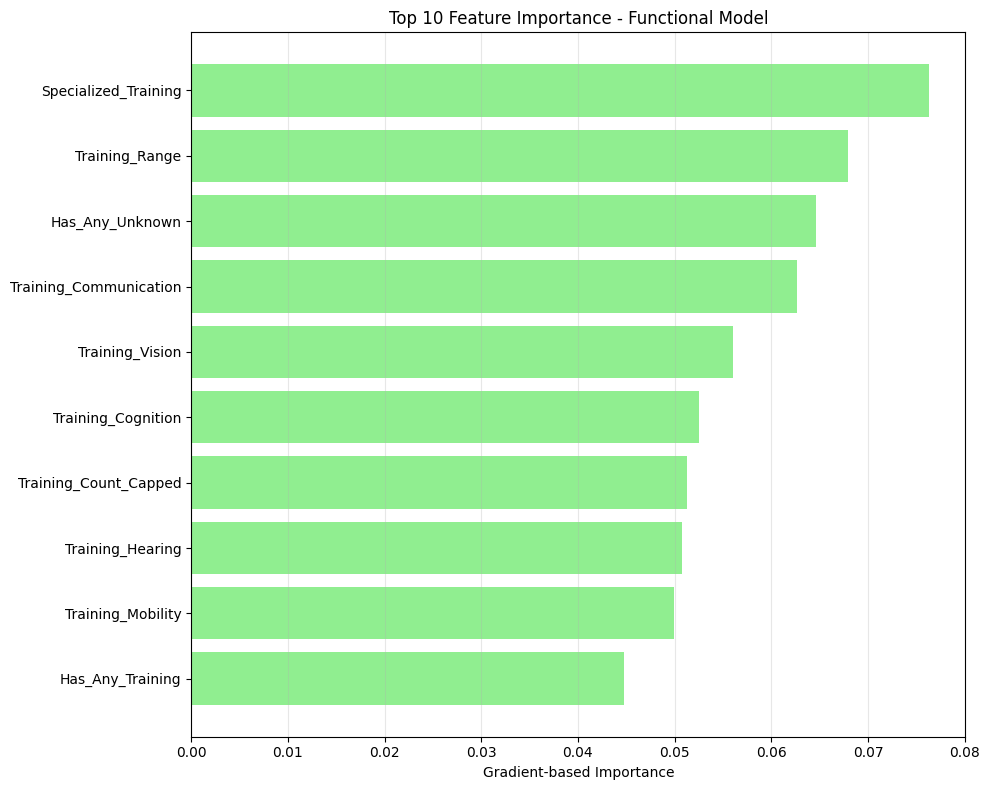

 Deep Learning Functional API Model Complete!


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE FOR FUNCTIONAL MODEL
# ============================================================================

print("\n CALCULATING FEATURE IMPORTANCE FOR FUNCTIONAL MODEL...")

# Calculate gradient-based importance for functional model
X_sample_tensor_func = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(X_sample_tensor_func)
    predictions_func = functional_model(X_sample_tensor_func)

gradients_func = tape.gradient(predictions_func, X_sample_tensor_func)
gradient_importance_func = np.mean(np.abs(gradients_func.numpy()), axis=0)

# Create feature importance dataframe
func_feature_importance_df = pd.DataFrame({
    'Feature': safe_feature_cols,
    'Importance': gradient_importance_func
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (Functional Model):")
print(func_feature_importance_df.head(10).round(4).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_func_features = func_feature_importance_df.head(10)
plt.barh(top_func_features['Feature'], top_func_features['Importance'], color='lightgreen')
plt.xlabel('Gradient-based Importance')
plt.title('Top 10 Feature Importance - Functional Model')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(" Deep Learning Functional API Model Complete!")

In [ ]:
# ============================================================================
# SECTION 6: TF.DATA API IMPLEMENTATION
# ============================================================================

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("SECTION 6: TF.DATA API IMPLEMENTATION")
print("="*80 + "\n")

# Clear any previous sessions
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

print(" IMPLEMENTING TF.DATA PIPELINE FOR OPTIMIZED DATA LOADING...")

# Enhanced TF.Data pipeline parameters
BATCH_SIZE = 16
SHUFFLE_BUFFER = 1000  # Larger buffer for better shuffling
PREFETCH_BUFFER = tf.data.AUTOTUNE

# Create optimized datasets
def create_tfdata_pipeline(X, y, batch_size, shuffle=False, buffer_size=1000):
    """Create optimized TF.Data pipeline"""
    dataset = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(PREFETCH_BUFFER)

    return dataset

# Create training and test datasets
train_dataset = create_tfdata_pipeline(X_train_scaled, y_train, BATCH_SIZE, shuffle=True, buffer_size=SHUFFLE_BUFFER)
test_dataset = create_tfdata_pipeline(X_test_scaled, y_test, BATCH_SIZE, shuffle=False)

print(f" Dataset Information:")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Test samples: {len(X_test_scaled)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_dataset)}")
print(f"  Test batches: {len(test_dataset)}")

# Enhanced model architecture for TF.Data
tfdata_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                         kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(1, activation='sigmoid')
], name='TFData_Model')

# Display model architecture
print("\n TF.DATA MODEL ARCHITECTURE:")
tfdata_model.summary()

# Enhanced compilation
tfdata_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Enhanced callbacks for TF.Data
early_stop_tfdata = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=25,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr_tfdata = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

checkpoint_tfdata = tf.keras.callbacks.ModelCheckpoint(
    'best_tfdata_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Calculate steps per epoch for TF.Data
steps_per_epoch = len(X_train_scaled) // BATCH_SIZE
validation_steps = len(X_test_scaled) // BATCH_SIZE

print(f"\n TRAINING CONFIGURATION:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")
print(f"  Total epochs: 150")

# Train the model with TF.Data pipeline
print("\n TRAINING TF.DATA MODEL...")
history_tfdata = tfdata_model.fit(
    train_dataset,
    epochs=150,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stop_tfdata, reduce_lr_tfdata, checkpoint_tfdata],
    verbose=1
)

# Load the best model
tfdata_model = tf.keras.models.load_model('best_tfdata_model.h5')
print(" Loaded best TF.Data model from checkpoint")

# Make predictions using the test dataset
print("\n MAKING PREDICTIONS...")
tfdata_pred_probs = tfdata_model.predict(test_dataset, verbose=0)
tfdata_pred = (tfdata_pred_probs > 0.5).astype(int).flatten()

# Calculate comprehensive metrics
tfdata_acc = accuracy_score(y_test, tfdata_pred)
tfdata_precision = precision_score(y_test, tfdata_pred)
tfdata_recall = recall_score(y_test, tfdata_pred)
tfdata_f1 = f1_score(y_test, tfdata_pred)
tfdata_auc = roc_auc_score(y_test, tfdata_pred_probs)

print(f"\n TF.DATA MODEL PERFORMANCE:")
print(f"  Accuracy:  {tfdata_acc:.4f}")
print(f"  Precision: {tfdata_precision:.4f}")
print(f"  Recall:    {tfdata_recall:.4f}")
print(f"  F1-Score:  {tfdata_f1:.4f}")
print(f"  AUC:       {tfdata_auc:.4f}")

# Store results
ml_results['TF.Data Model'] = {
    'model': tfdata_model,
    'history': history_tfdata,
    'accuracy': tfdata_acc,
    'precision': tfdata_precision,
    'recall': tfdata_recall,
    'f1_score': tfdata_f1,
    'auc': tfdata_auc,
    'predictions': tfdata_pred,
    'probabilities': tfdata_pred_probs.flatten()
}


SECTION 6: TF.DATA API IMPLEMENTATION

 IMPLEMENTING TF.DATA PIPELINE FOR OPTIMIZED DATA LOADING...
 Dataset Information:
  Training samples: 57
  Test samples: 15
  Batch size: 16
  Training batches: 4
  Test batches: 1

 TF.DATA MODEL ARCHITECTURE:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "TFData_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 448 (1.75 KB)


 TRAINING CONFIGURATION:
  Steps per epoch: 3
  Validation steps: 0
  Total epochs: 150

 TRAINING TF.DATA MODEL...
Epoch 1/150
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5000 - auc: 0.5833 - loss: 0.9685 - precision: 0.4167 - recall: 0.8333

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4141 - auc: 0.5830 - loss: 1.1480 - precision: 0.3024 - recall: 0.8816 - val_accuracy: 0.2667 - val_auc: 0.9583 - val_loss: 0.8072 - val_precision: 0.2143 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/150
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4444 - auc: 0.8750 - loss: 1.1150 - precision: 0.1667 - recall: 1.0000

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4444 - auc: 0.8750 - loss: 1.1150 - precision: 0.1667 - recall: 1.0000 - val_accuracy: 0.2667 - val_auc: 1.0000 - val_loss: 0.7986 - val_precision: 0.2143 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5339 - auc: 0.8910 - loss: 0.8611 - precision: 0.3318 - recall: 0.9545 - val_accuracy: 0.2667 - val_auc: 1.0000 - val_loss: 0.7789 - val_precision: 0.2143 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3333 - auc: 0.5000 - loss: 1.0667 - precision: 0.1429 - recall: 1.0000 - val_accuracy: 0.2667 - val_auc: 1.0000 - val_loss: 0.7635 - val_precision: 0.2143 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4245 - auc: 0.7531 - loss: 1.0799 - precision: 0.2365 - recall: 0.9143 - val_accuracy: 0.2667 - val_auc: 1.0000 - val_loss: 0.7272 - val_precision: 0.2143 -

 Loaded best TF.Data model from checkpoint

 MAKING PREDICTIONS...



 TF.DATA MODEL PERFORMANCE:
  Accuracy:  0.2667
  Precision: 0.2143
  Recall:    1.0000
  F1-Score:  0.3529
  AUC:       1.0000



 PLOTTING TF.DATA TRAINING HISTORY...


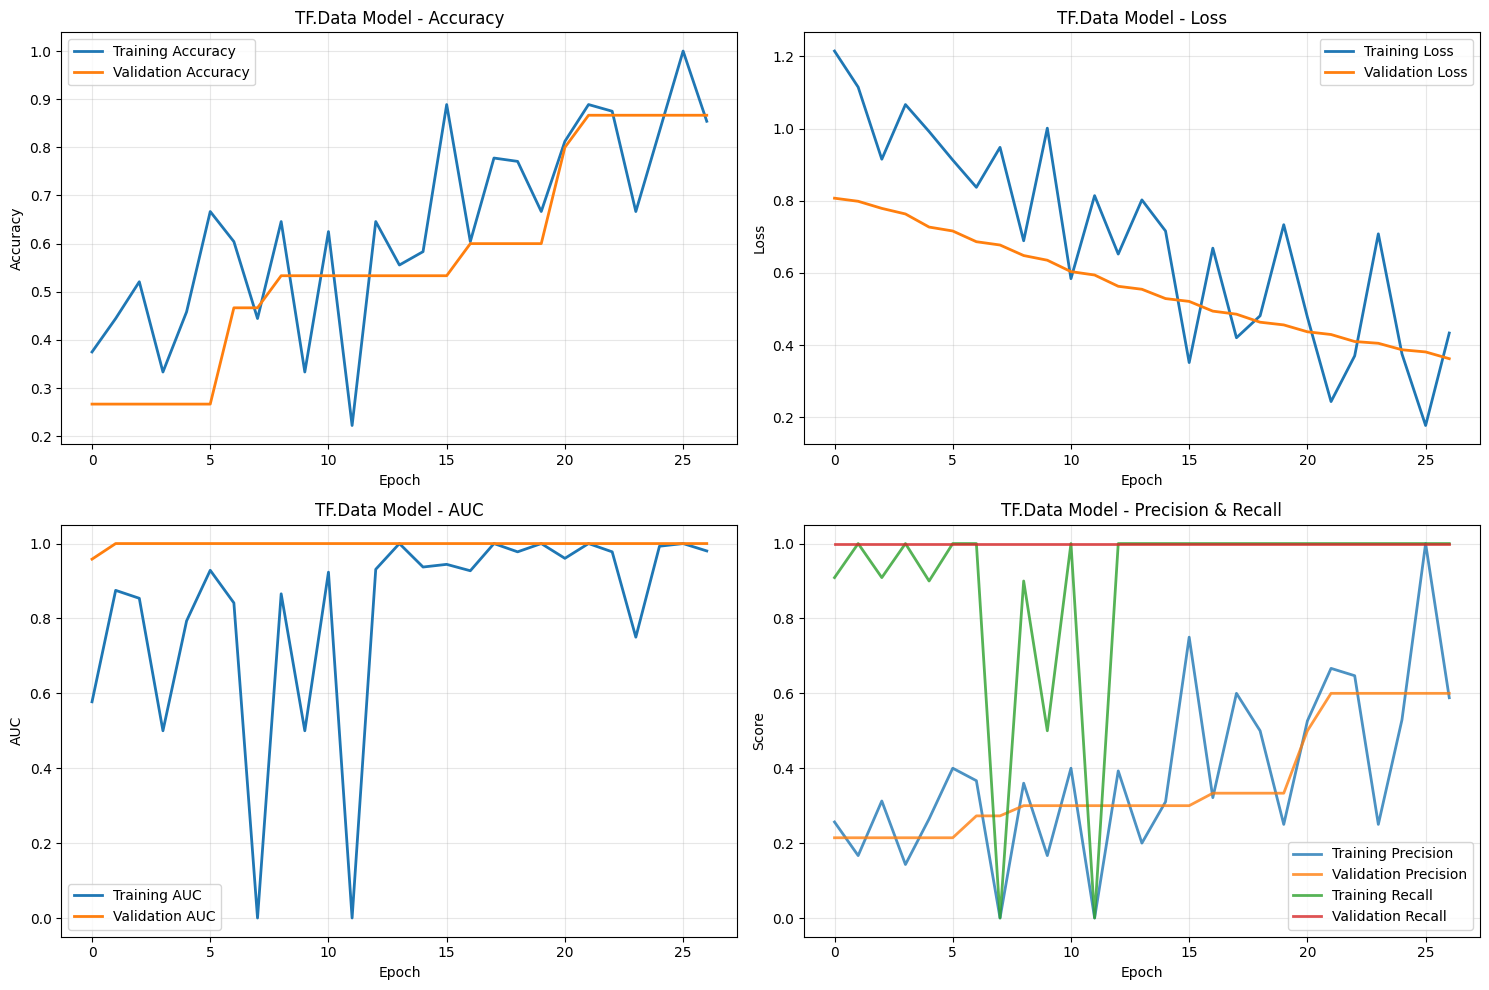

In [ ]:
# ============================================================================
# TRAINING VISUALIZATION
# ============================================================================

print("\n PLOTTING TF.DATA TRAINING HISTORY...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history_tfdata.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history_tfdata.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('TF.Data Model - Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[0, 1].plot(history_tfdata.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history_tfdata.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('TF.Data Model - Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot training & validation AUC
axes[1, 0].plot(history_tfdata.history['auc'], label='Training AUC', linewidth=2)
axes[1, 0].plot(history_tfdata.history['val_auc'], label='Validation AUC', linewidth=2)
axes[1, 0].set_title('TF.Data Model - AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot precision and recall
axes[1, 1].plot(history_tfdata.history['precision'], label='Training Precision', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_tfdata.history['val_precision'], label='Validation Precision', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_tfdata.history['recall'], label='Training Recall', linewidth=2, alpha=0.8)
axes[1, 1].plot(history_tfdata.history['val_recall'], label='Validation Recall', linewidth=2, alpha=0.8)
axes[1, 1].set_title('TF.Data Model - Precision & Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PERFORMANCE COMPARISON
# ============================================================================

print("\n" + "="*60)
print("DEEP LEARNING MODELS COMPARISON")
print("="*60)

# Compare all deep learning models
dl_models = ['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']

comparison_data = []
for model_name in dl_models:
    if model_name in ml_results:
        results = ml_results[model_name]
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1_score'],
            'AUC': results['auc']
        })

dl_comparison_df = pd.DataFrame(comparison_data).round(4)
print(dl_comparison_df.to_string(index=False))


DEEP LEARNING MODELS COMPARISON
                      Model  Accuracy  Precision  Recall  F1-Score  AUC
Neural Network (Sequential)    1.0000     1.0000     1.0    1.0000  1.0
           Functional Model    0.4667     0.2727     1.0    0.4286  1.0
              TF.Data Model    0.2667     0.2143     1.0    0.3529  1.0



 TF.DATA PIPELINE ANALYSIS:
Training completed in 27 epochs
Final Training Loss: 0.4335
Final Validation Loss: 0.3624
Final Training AUC: 0.9803
Final Validation AUC: 1.0000

 CONFIDENCE ANALYSIS - TF.DATA MODEL:
High confidence predictions (>0.8 or <0.2): 0/15 (0.0%)
Medium confidence predictions (0.2-0.4 or 0.6-0.8): 9/15 (60.0%)
Low confidence predictions (0.4-0.6): 6/15 (40.0%)


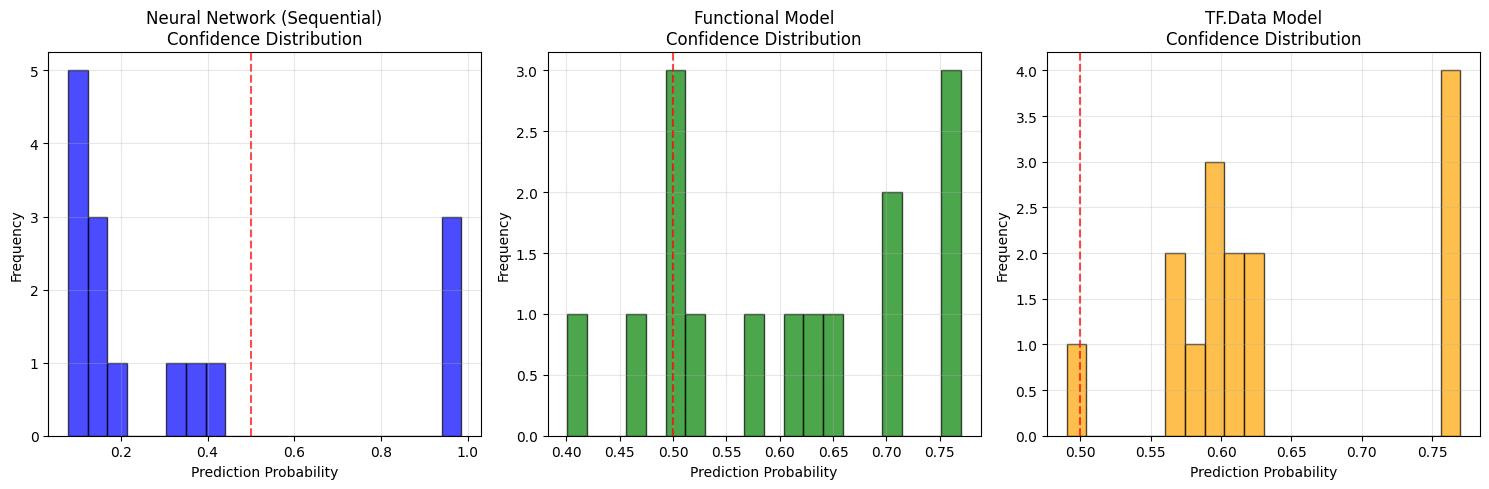

In [ ]:
# ============================================================================
# TF.DATA SPECIFIC ANALYSIS
# ============================================================================

print("\n TF.DATA PIPELINE ANALYSIS:")

# Analyze training efficiency
total_epochs_trained = len(history_tfdata.history['loss'])
final_training_loss = history_tfdata.history['loss'][-1]
final_validation_loss = history_tfdata.history['val_loss'][-1]
final_training_auc = history_tfdata.history['auc'][-1]
final_validation_auc = history_tfdata.history['val_auc'][-1]

print(f"Training completed in {total_epochs_trained} epochs")
print(f"Final Training Loss: {final_training_loss:.4f}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")
print(f"Final Training AUC: {final_training_auc:.4f}")
print(f"Final Validation AUC: {final_validation_auc:.4f}")

# Confidence analysis for TF.Data model
print("\n CONFIDENCE ANALYSIS - TF.DATA MODEL:")
tfdata_confidence_scores = tfdata_pred_probs.flatten()
tfdata_high_confidence = (tfdata_confidence_scores > 0.8) | (tfdata_confidence_scores < 0.2)
tfdata_medium_confidence = ((tfdata_confidence_scores >= 0.6) & (tfdata_confidence_scores <= 0.8)) | ((tfdata_confidence_scores >= 0.2) & (tfdata_confidence_scores < 0.4))
tfdata_low_confidence = (tfdata_confidence_scores >= 0.4) & (tfdata_confidence_scores < 0.6)

print(f"High confidence predictions (>0.8 or <0.2): {tfdata_high_confidence.sum()}/{len(tfdata_confidence_scores)} ({tfdata_high_confidence.mean():.1%})")
print(f"Medium confidence predictions (0.2-0.4 or 0.6-0.8): {tfdata_medium_confidence.sum()}/{len(tfdata_confidence_scores)} ({tfdata_medium_confidence.mean():.1%})")
print(f"Low confidence predictions (0.4-0.6): {tfdata_low_confidence.sum()}/{len(tfdata_confidence_scores)} ({tfdata_low_confidence.mean():.1%})")

# Compare confidence distributions across all models
plt.figure(figsize=(15, 5))

models_to_compare = ['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']
colors = ['blue', 'green', 'orange']

for i, model_name in enumerate(models_to_compare):
    if model_name in ml_results:
        plt.subplot(1, 3, i+1)
        confidence_scores = ml_results[model_name]['probabilities']
        plt.hist(confidence_scores, bins=20, alpha=0.7, color=colors[i], edgecolor='black')
        plt.axvline(0.5, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Prediction Probability')
        plt.ylabel('Frequency')
        plt.title(f'{model_name}\nConfidence Distribution')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# BENCHMARK COMPARISON
# ============================================================================

print("\n" + "="*50)
print("BENCHMARK: TF.DATA VS TRADITIONAL TRAINING")
print("="*50)

# Compare TF.Data with traditional sequential model
if 'Neural Network (Sequential)' in ml_results:
    seq_results = ml_results['Neural Network (Sequential)']
    tfdata_results = ml_results['TF.Data Model']

    print("\n📊 PERFORMANCE COMPARISON:")
    print(f"{'Metric':<12} {'Sequential':<12} {'TF.Data':<12} {'Difference':<12}")
    print("-" * 50)

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

    for metric, name in zip(metrics, metric_names):
        seq_val = seq_results[metric]
        tfdata_val = tfdata_results[metric]
        diff = tfdata_val - seq_val
        diff_str = f"{'+' if diff > 0 else ''}{diff:.4f}"

        print(f"{name:<12} {seq_val:<12.4f} {tfdata_val:<12.4f} {diff_str:<12}")



BENCHMARK: TF.DATA VS TRADITIONAL TRAINING

📊 PERFORMANCE COMPARISON:
Metric       Sequential   TF.Data      Difference  
--------------------------------------------------
Accuracy     1.0000       0.2667       -0.7333     
Precision    1.0000       0.2143       -0.7857     
Recall       1.0000       1.0000       0.0000      
F1-Score     1.0000       0.3529       -0.6471     
AUC          1.0000       1.0000       0.0000      



 CALCULATING FEATURE IMPORTANCE FOR TF.DATA MODEL...

Top 10 Most Important Features (TF.Data Model):
               Feature  Importance
       Has_Any_Unknown      0.0510
  Specialized_Training      0.0458
     Training_Variance      0.0443
        Training_Range      0.0420
     Training_Mobility      0.0412
 Training_Count_Capped      0.0389
      Has_Any_Training      0.0358
      Training_Hearing      0.0352
Training_Communication      0.0338
    Training_Self_care      0.0328


<Figure size 1200x800 with 0 Axes>

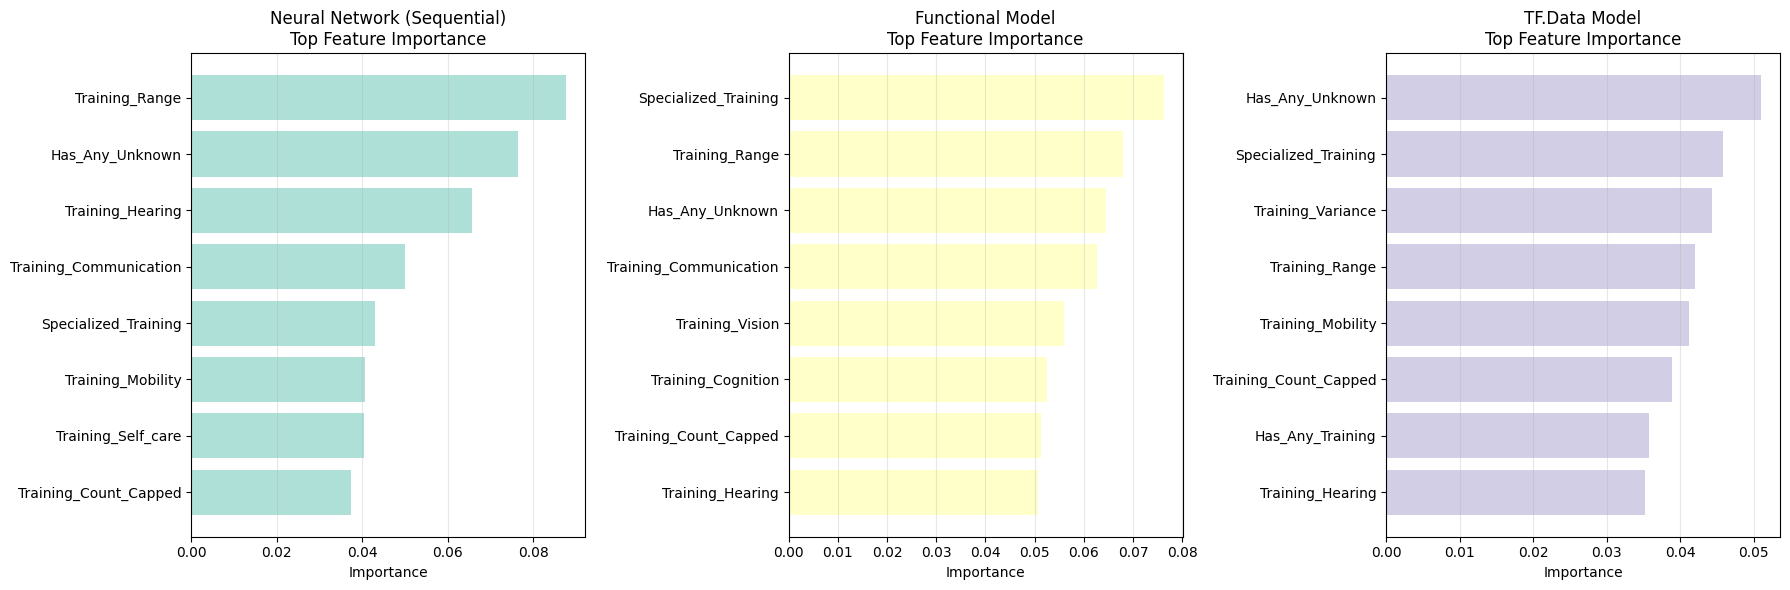

 TF.Data API Implementation Complete!


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE FOR TF.DATA MODEL
# ============================================================================

print("\n CALCULATING FEATURE IMPORTANCE FOR TF.DATA MODEL...")

# Calculate gradient-based importance
X_sample_tensor_tfdata = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(X_sample_tensor_tfdata)
    predictions_tfdata = tfdata_model(X_sample_tensor_tfdata)

gradients_tfdata = tape.gradient(predictions_tfdata, X_sample_tensor_tfdata)
gradient_importance_tfdata = np.mean(np.abs(gradients_tfdata.numpy()), axis=0)

# Create feature importance dataframe
tfdata_feature_importance_df = pd.DataFrame({
    'Feature': safe_feature_cols,
    'Importance': gradient_importance_tfdata
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (TF.Data Model):")
print(tfdata_feature_importance_df.head(10).round(4).to_string(index=False))

# Plot feature importance comparison
plt.figure(figsize=(12, 8))

# Get feature importance from all models for comparison
importance_data = []
for model_name in ['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']:
    if model_name in ml_results:
        # Recalculate importance for consistency
        model = ml_results[model_name]['model']
        X_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(X_tensor)
            predictions = model(X_tensor)

        gradients = tape.gradient(predictions, X_tensor)
        importance = np.mean(np.abs(gradients.numpy()), axis=0)

        for i, feature in enumerate(safe_feature_cols):
            importance_data.append({
                'Feature': feature,
                'Importance': importance[i],
                'Model': model_name
            })

importance_df = pd.DataFrame(importance_data)

# Plot top features for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, model_name in enumerate(['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']):
    if model_name in ml_results:
        model_importance = importance_df[importance_df['Model'] == model_name]
        top_features = model_importance.nlargest(8, 'Importance')

        axes[i].barh(top_features['Feature'], top_features['Importance'],
                    color=plt.cm.Set3(i), alpha=0.7)
        axes[i].set_title(f'{model_name}\nTop Feature Importance')
        axes[i].set_xlabel('Importance')
        axes[i].invert_yaxis()
        axes[i].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(" TF.Data API Implementation Complete!")

In [ ]:
# ============================================================================
# SECTION 7: COMPREHENSIVE MODEL COMPARISON
# ============================================================================

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n" + "="*80)
print("SECTION 7: COMPREHENSIVE MODEL COMPARISON")
print("="*80 + "\n")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


SECTION 7: COMPREHENSIVE MODEL COMPARISON



In [ ]:
# ============================================================================
# PERFORMANCE METRICS COMPARISON
# ============================================================================

print(" CALCULATING COMPREHENSIVE PERFORMANCE METRICS...")

comparison_data = []
roc_data = {}
pr_data = {}

for model_name, results in ml_results.items():
    # Calculate basic metrics
    accuracy = results['accuracy']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1_score']
    auc_score = results.get('auc', None)

    # Calculate additional metrics if probabilities are available
    if 'probabilities' in results and results['probabilities'] is not None:
        probabilities = results['probabilities']

        # ROC curve data
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

        # Precision-Recall curve data
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, probabilities)
        pr_auc = auc(recall_curve, precision_curve)
        pr_data[model_name] = {'precision': precision_curve, 'recall': recall_curve, 'auc': pr_auc}

        # Use calculated AUC if available, otherwise use ROC AUC
        if auc_score is None:
            auc_score = roc_auc
    else:
        roc_auc = None
        pr_auc = None

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, results['predictions'])
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2

    comparison_data.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_accuracy,
        'AUC': auc_score,
        'PR-AUC': pr_auc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })

# Create comprehensive comparison dataframe
final_comparison = pd.DataFrame(comparison_data)

# Sort by multiple criteria (primary: F1-Score, secondary: Accuracy)
final_comparison['Composite_Score'] = (
    final_comparison['F1-Score'] * 0.4 +
    final_comparison['Accuracy'] * 0.3 +
    final_comparison['AUC'] * 0.3
)
final_comparison = final_comparison.sort_values('Composite_Score', ascending=False)

print("\n" + "="*70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*70)

# Display main metrics
display_columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'Balanced Accuracy']
print(final_comparison[display_columns].round(4).to_string(index=False))

# Display additional metrics
print("\n" + "="*50)
print("ADDITIONAL PERFORMANCE METRICS")
print("="*50)
additional_columns = ['Model', 'Specificity', 'PR-AUC', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives']
print(final_comparison[additional_columns].round(4).to_string(index=False))

# Identify best model
best_model_row = final_comparison.iloc[0]
best_model_name = best_model_row['Model']
best_model_results = ml_results[best_model_name]

print(f"\n BEST OVERALL MODEL: {best_model_name}")
print(f"   F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"   AUC: {best_model_row['AUC']:.4f}")
print(f"   Composite Score: {best_model_row['Composite_Score']:.4f}")

 CALCULATING COMPREHENSIVE PERFORMANCE METRICS...

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
                      Model  Accuracy  Precision  Recall  F1-Score  AUC  Balanced Accuracy
        Logistic Regression    1.0000     1.0000     1.0    1.0000  1.0             1.0000
              Decision Tree    1.0000     1.0000     1.0    1.0000  1.0             1.0000
              Random Forest    1.0000     1.0000     1.0    1.0000  1.0             1.0000
                        SVM    1.0000     1.0000     1.0    1.0000  1.0             1.0000
          Gradient Boosting    1.0000     1.0000     1.0    1.0000  1.0             1.0000
      Random Forest (Tuned)    1.0000     1.0000     1.0    1.0000  1.0             1.0000
Logistic Regression (Tuned)    1.0000     1.0000     1.0    1.0000  1.0             1.0000
  Gradient Boosting (Tuned)    1.0000     1.0000     1.0    1.0000  1.0             1.0000
Neural Network (Sequential)    1.0000     1.0000     1.0    1.0000  1.0             1.0


 CREATING COMPREHENSIVE VISUALIZATIONS...


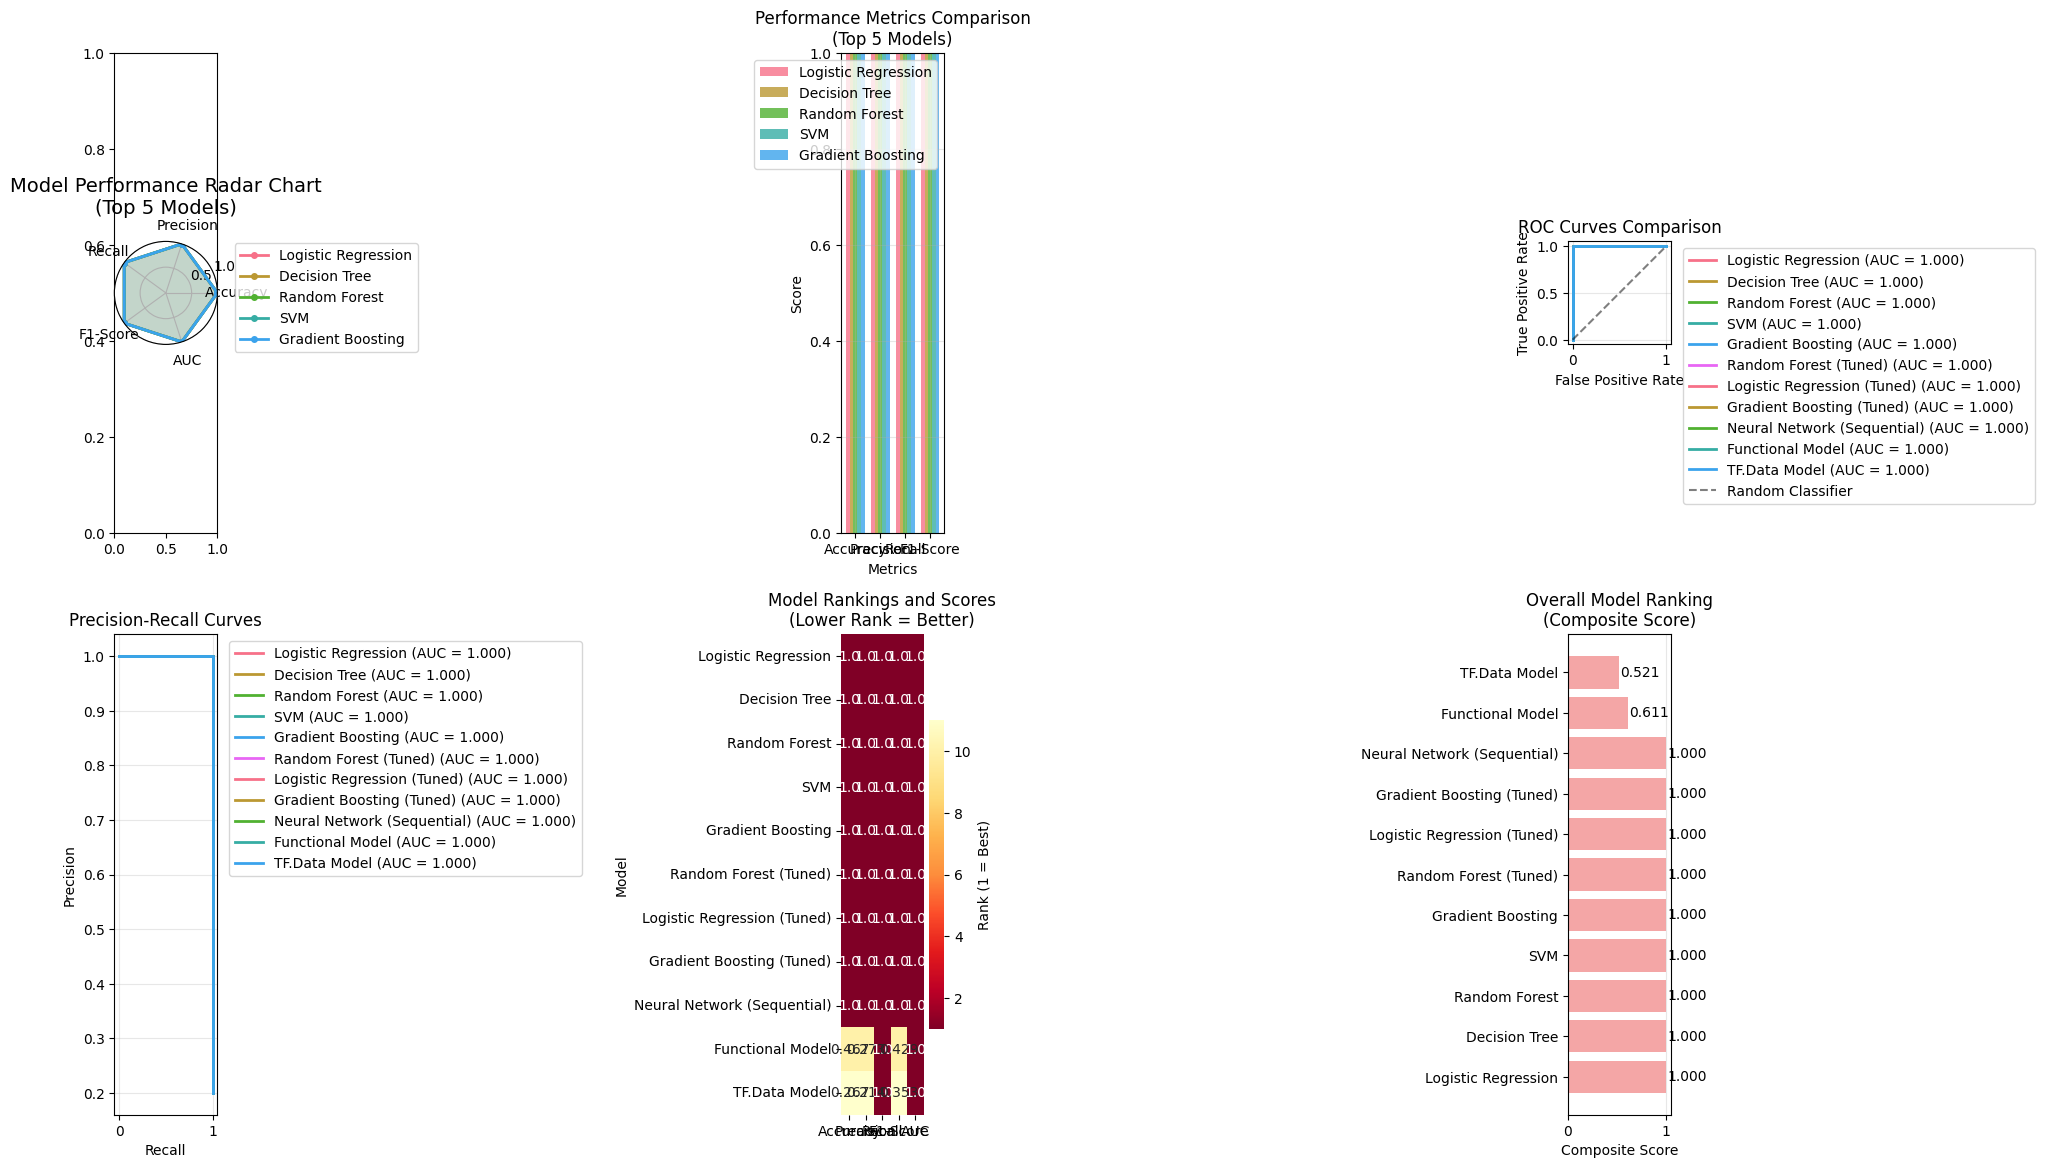

In [ ]:
# ============================================================================
# VISUALIZATION 1: RADAR CHART COMPARISON
# ============================================================================

print("\n CREATING COMPREHENSIVE VISUALIZATIONS...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Radar Chart for Top 5 Models
top_models = final_comparison.head(5)['Model'].tolist()

# Metrics for radar chart
metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Create radar chart
ax1 = plt.subplot(2, 3, 1, polar=True)
for i, model_name in enumerate(top_models):
    model_data = final_comparison[final_comparison['Model'] == model_name].iloc[0]
    values = [model_data[metric] for metric in metrics_radar]
    values += values[:1]  # Complete the circle

    ax1.plot(angles, values, 'o-', linewidth=2, label=model_name, markersize=4)
    ax1.fill(angles, values, alpha=0.1)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics_radar)
ax1.set_ylim(0, 1)
ax1.set_title('Model Performance Radar Chart\n(Top 5 Models)', size=14, pad=20)
ax1.legend(bbox_to_anchor=(1.1, 1.05))

# 2. Bar Chart - Main Metrics Comparison
metrics_bar = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics_bar))
width = 0.15

ax2 = plt.subplot(2, 3, 2)
for i, model_name in enumerate(top_models):
    model_data = final_comparison[final_comparison['Model'] == model_name].iloc[0]
    scores = [model_data[metric] for metric in metrics_bar]
    ax2.bar(x_pos + i*width, scores, width, label=model_name, alpha=0.8)

ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_title('Performance Metrics Comparison\n(Top 5 Models)')
ax2.set_xticks(x_pos + width*2)
ax2.set_xticklabels(metrics_bar)
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# 3. ROC Curves
ax3 = plt.subplot(2, 3, 3)
for model_name, data in roc_data.items():
    ax3.plot(data['fpr'], data['tpr'],
             label=f'{model_name} (AUC = {data["auc"]:.3f})',
             linewidth=2)

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

# 4. Precision-Recall Curves
ax4 = plt.subplot(2, 3, 4)
for model_name, data in pr_data.items():
    ax4.plot(data['recall'], data['precision'],
             label=f'{model_name} (AUC = {data["auc"]:.3f})',
             linewidth=2)

ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curves')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. Model Ranking Heatmap
ax5 = plt.subplot(2, 3, 5)
ranking_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
rank_data = final_comparison[['Model'] + ranking_metrics].set_index('Model')

# Create rankings (1 is best)
rankings = rank_data.rank(ascending=False, method='min')
sns.heatmap(rankings, annot=rank_data.round(3), fmt='', cmap='YlOrRd_r',
            cbar_kws={'label': 'Rank (1 = Best)'}, ax=ax5)
ax5.set_title('Model Rankings and Scores\n(Lower Rank = Better)')

# 6. Composite Score Comparison
ax6 = plt.subplot(2, 3, 6)
models_ordered = final_comparison['Model'].tolist()
scores_ordered = final_comparison['Composite_Score'].tolist()

bars = ax6.barh(models_ordered, scores_ordered, color='lightcoral', alpha=0.7)
ax6.set_xlabel('Composite Score')
ax6.set_title('Overall Model Ranking\n(Composite Score)')
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar, score in zip(bars, scores_ordered):
    ax6.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()


 CONFUSION MATRICES FOR TOP 3 MODELS:


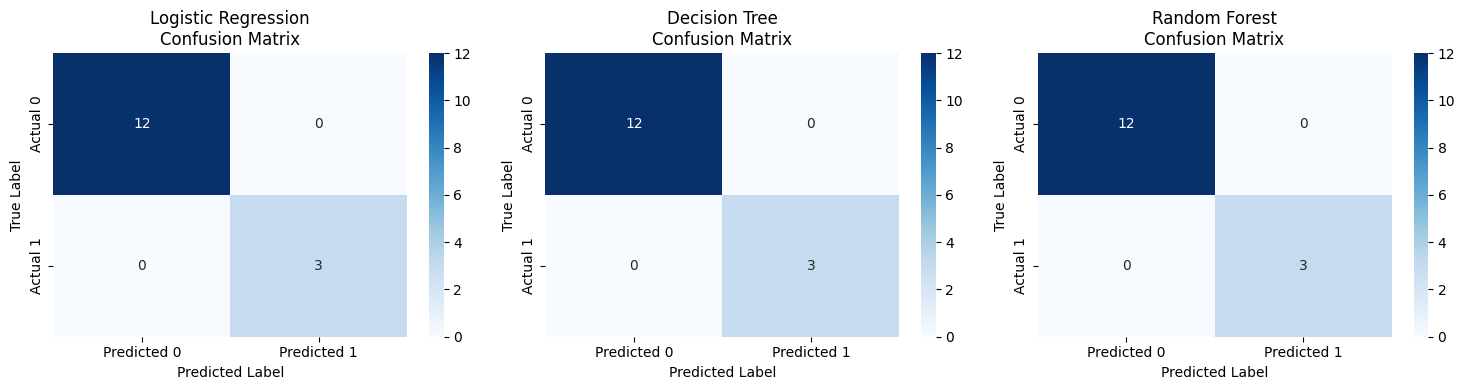

In [ ]:
# ============================================================================
# CONFUSION MATRICES FOR TOP MODELS
# ============================================================================

print("\n CONFUSION MATRICES FOR TOP 3 MODELS:")

top_3_models = final_comparison.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, model_name in enumerate(top_3_models):
    results = ml_results[model_name]
    cm = confusion_matrix(y_test, results['predictions'])

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    ax.set_title(f'{model_name}\nConfusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

print("\n STATISTICAL COMPARISON:")

from scipy.stats import friedmanchisquare

# Prepare data for statistical testing
if len(ml_results) >= 3:  # Need at least 3 models for Friedman test
    accuracy_scores = []
    f1_scores = []

    for model_name in final_comparison['Model']:
        results = ml_results[model_name]
        accuracy_scores.append(results['accuracy'])
        f1_scores.append(results['f1_score'])

    # Friedman test for accuracy
    try:
        friedman_acc = friedmanchisquare(*accuracy_scores)
        print(f"Friedman Test - Accuracy: χ²={friedman_acc.statistic:.3f}, p-value={friedman_acc.pvalue:.3f}")
    except:
        print("Could not perform Friedman test on accuracy scores")

    # Friedman test for F1-score
    try:
        friedman_f1 = friedmanchisquare(*f1_scores)
        print(f"Friedman Test - F1-Score: χ²={friedman_f1.statistic:.3f}, p-value={friedman_f1.pvalue:.3f}")
    except:
        print("Could not perform Friedman test on F1 scores")


 STATISTICAL COMPARISON:
Friedman Test - Accuracy: χ²=10.000, p-value=0.440
Friedman Test - F1-Score: χ²=10.000, p-value=0.440


In [ ]:
# ============================================================================
# MODEL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*60)
print("MODEL SELECTION RECOMMENDATIONS")
print("="*60)

print("\n BASED ON BUSINESS OBJECTIVES:")

# Recommendation based on different objectives
objectives = {
    'High Precision (Minimize False Positives)': final_comparison.nlargest(1, 'Precision')['Model'].iloc[0],
    'High Recall (Minimize False Negatives)': final_comparison.nlargest(1, 'Recall')['Model'].iloc[0],
    'Balanced Performance (Best F1-Score)': final_comparison.nlargest(1, 'F1-Score')['Model'].iloc[0],
    'Overall Accuracy': final_comparison.nlargest(1, 'Accuracy')['Model'].iloc[0],
    'Best AUC Score': final_comparison.nlargest(1, 'AUC')['Model'].iloc[0]
}

for objective, model in objectives.items():
    model_perf = final_comparison[final_comparison['Model'] == model].iloc[0]
    print(f"  {objective}:")
    print(f"    → {model}")
    if objective == 'High Precision (Minimize False Positives)':
        print(f"    Precision: {model_perf['Precision']:.4f}")
    elif objective == 'High Recall (Minimize False Negatives)':
        print(f"    Recall: {model_perf['Recall']:.4f}")
    elif objective == 'Balanced Performance (Best F1-Score)':
        print(f"    F1-Score: {model_perf['F1-Score']:.4f}")
    elif objective == 'Overall Accuracy':
        print(f"    Accuracy: {model_perf['Accuracy']:.4f}")
    else:
        print(f"    AUC: {model_perf['AUC']:.4f}")
    print()


MODEL SELECTION RECOMMENDATIONS

 BASED ON BUSINESS OBJECTIVES:
  High Precision (Minimize False Positives):
    → Logistic Regression
    Precision: 1.0000

  High Recall (Minimize False Negatives):
    → Logistic Regression
    Recall: 1.0000

  Balanced Performance (Best F1-Score):
    → Logistic Regression
    F1-Score: 1.0000

  Overall Accuracy:
    → Logistic Regression
    Accuracy: 1.0000

  Best AUC Score:
    → Logistic Regression
    AUC: 1.0000



In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"Total Models Evaluated: {len(ml_results)}")
print(f"Best Overall Model: {best_model_name}")
print(f"Test Set Size: {len(y_test)} samples")
print(f"Positive Class Prevalence: {y_test.mean():.1%}")

# Performance gaps
if len(final_comparison) > 1:
    best_f1 = final_comparison['F1-Score'].iloc[0]
    second_best_f1 = final_comparison['F1-Score'].iloc[1]
    f1_gap = best_f1 - second_best_f1

    best_acc = final_comparison['Accuracy'].iloc[0]
    second_best_acc = final_comparison['Accuracy'].iloc[1]
    acc_gap = best_acc - second_best_acc

    print(f"F1-Score Gap (Best vs 2nd): {f1_gap:.4f}")
    print(f"Accuracy Gap (Best vs 2nd): {acc_gap:.4f}")

print("\n COMPREHENSIVE MODEL COMPARISON COMPLETE!")


FINAL SUMMARY
Total Models Evaluated: 11
Best Overall Model: Logistic Regression
Test Set Size: 15 samples
Positive Class Prevalence: 20.0%
F1-Score Gap (Best vs 2nd): 0.0000
Accuracy Gap (Best vs 2nd): 0.0000

 COMPREHENSIVE MODEL COMPARISON COMPLETE!



SECTION 8: GENERATING VISUALIZATIONS

 Saved: comprehensive_model_analysis.png
 Saved: confusion_matrix.png


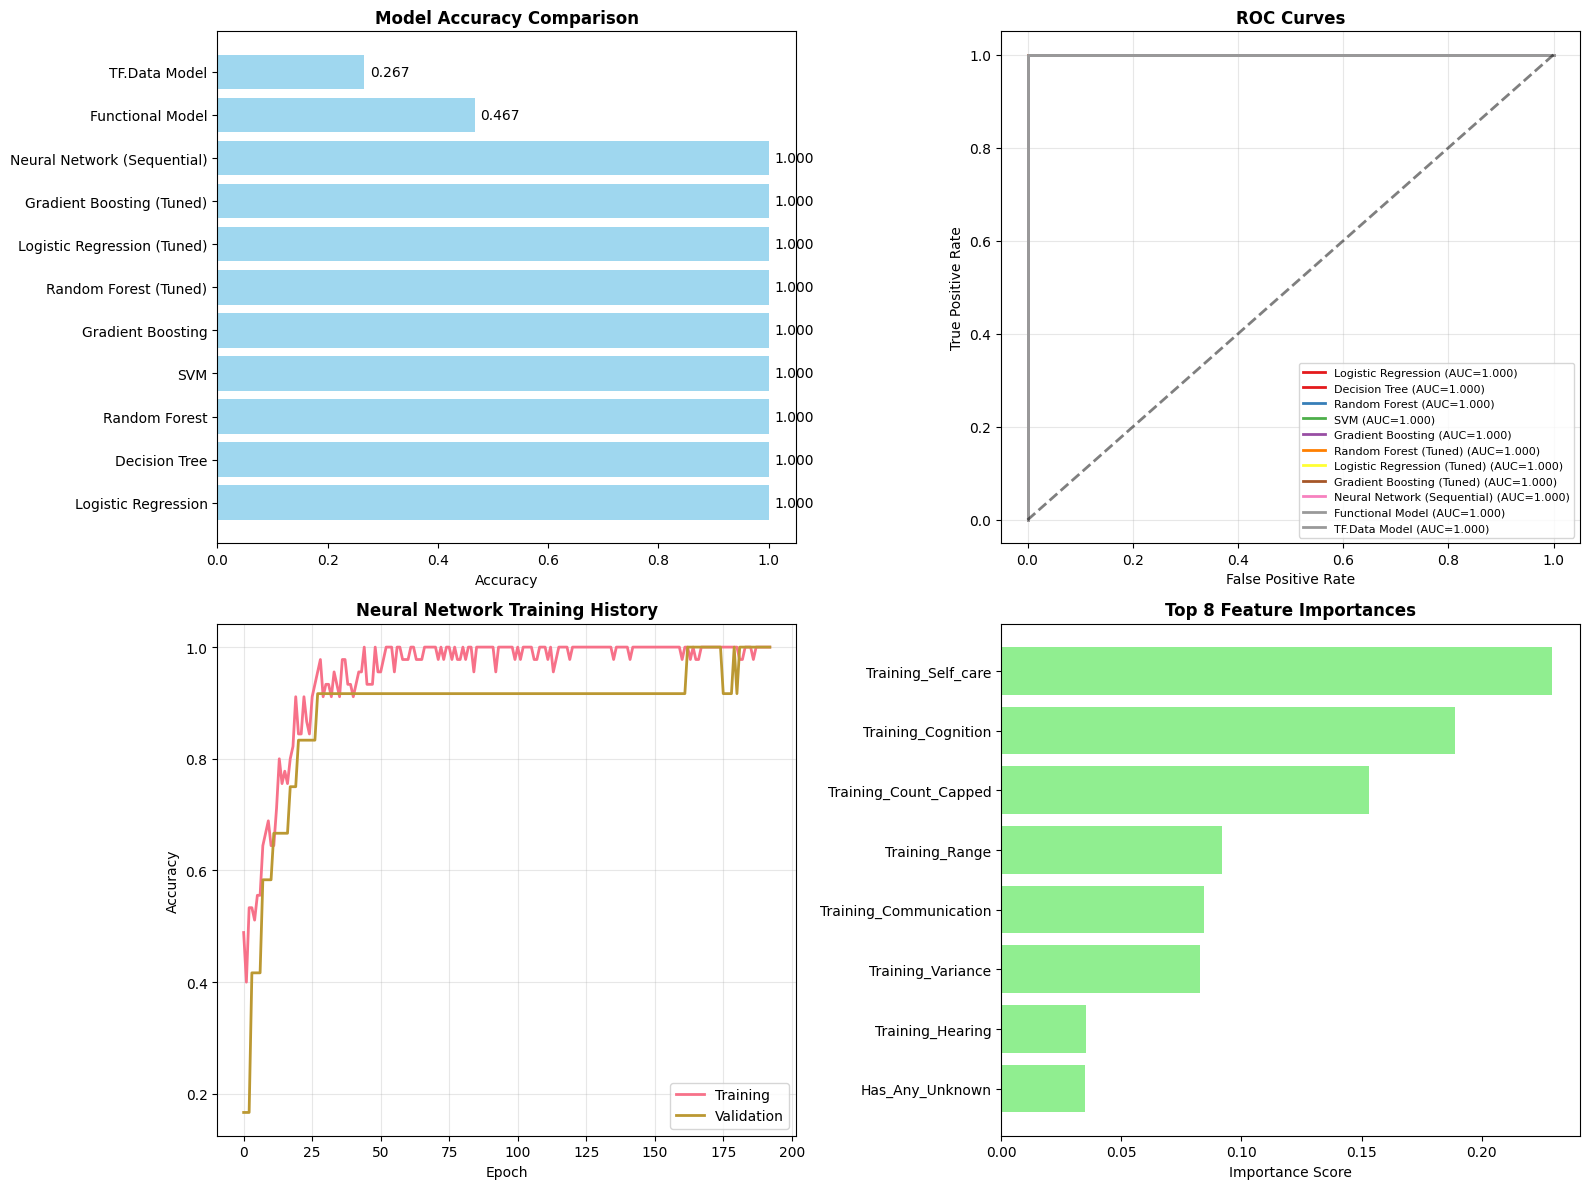

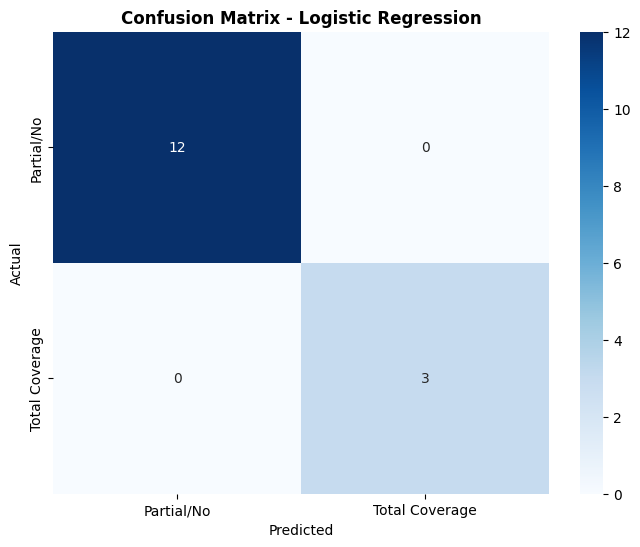

In [ ]:
# ============================================================================
# SECTION 8: VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("SECTION 8: GENERATING VISUALIZATIONS")
print("="*80 + "\n")

# 1. Model Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy Comparison
models_names = final_comparison['Model']
accuracies = final_comparison['Accuracy']
axes[0, 0].barh(models_names, accuracies, color='skyblue', alpha=0.8)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
for i, v in enumerate(accuracies):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# ROC Curves
colors = plt.cm.Set1(np.linspace(0, 1, len(ml_results)))
for i, (model_name, results) in enumerate(ml_results.items()):
    if 'probabilities' in results and results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        auc_score = auc(fpr, tpr)
        axes[0, 1].plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})',
                       linewidth=2, color=colors[i])
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves', fontweight='bold')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Neural Network Training History
axes[1, 0].plot(history_sequential.history['accuracy'], label='Training', linewidth=2)
axes[1, 0].plot(history_sequential.history['val_accuracy'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Neural Network Training History', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': safe_feature_cols,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True).tail(8)

axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], color='lightgreen')
axes[1, 1].set_xlabel('Importance Score')
axes[1, 1].set_title('Top 8 Feature Importances', fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_model_analysis.png', dpi=300, bbox_inches='tight')
print(" Saved: comprehensive_model_analysis.png")

# 2. Confusion Matrix
best_model_name = final_comparison.iloc[0]['Model']
best_predictions = ml_results[best_model_name]['predictions']

cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Partial/No', 'Total Coverage'],
            yticklabels=['Partial/No', 'Total Coverage'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print(" Saved: confusion_matrix.png")

 CREATING COMPREHENSIVE MODEL COMPARISON DASHBOARD...
 Saved: comprehensive_model_dashboard.png


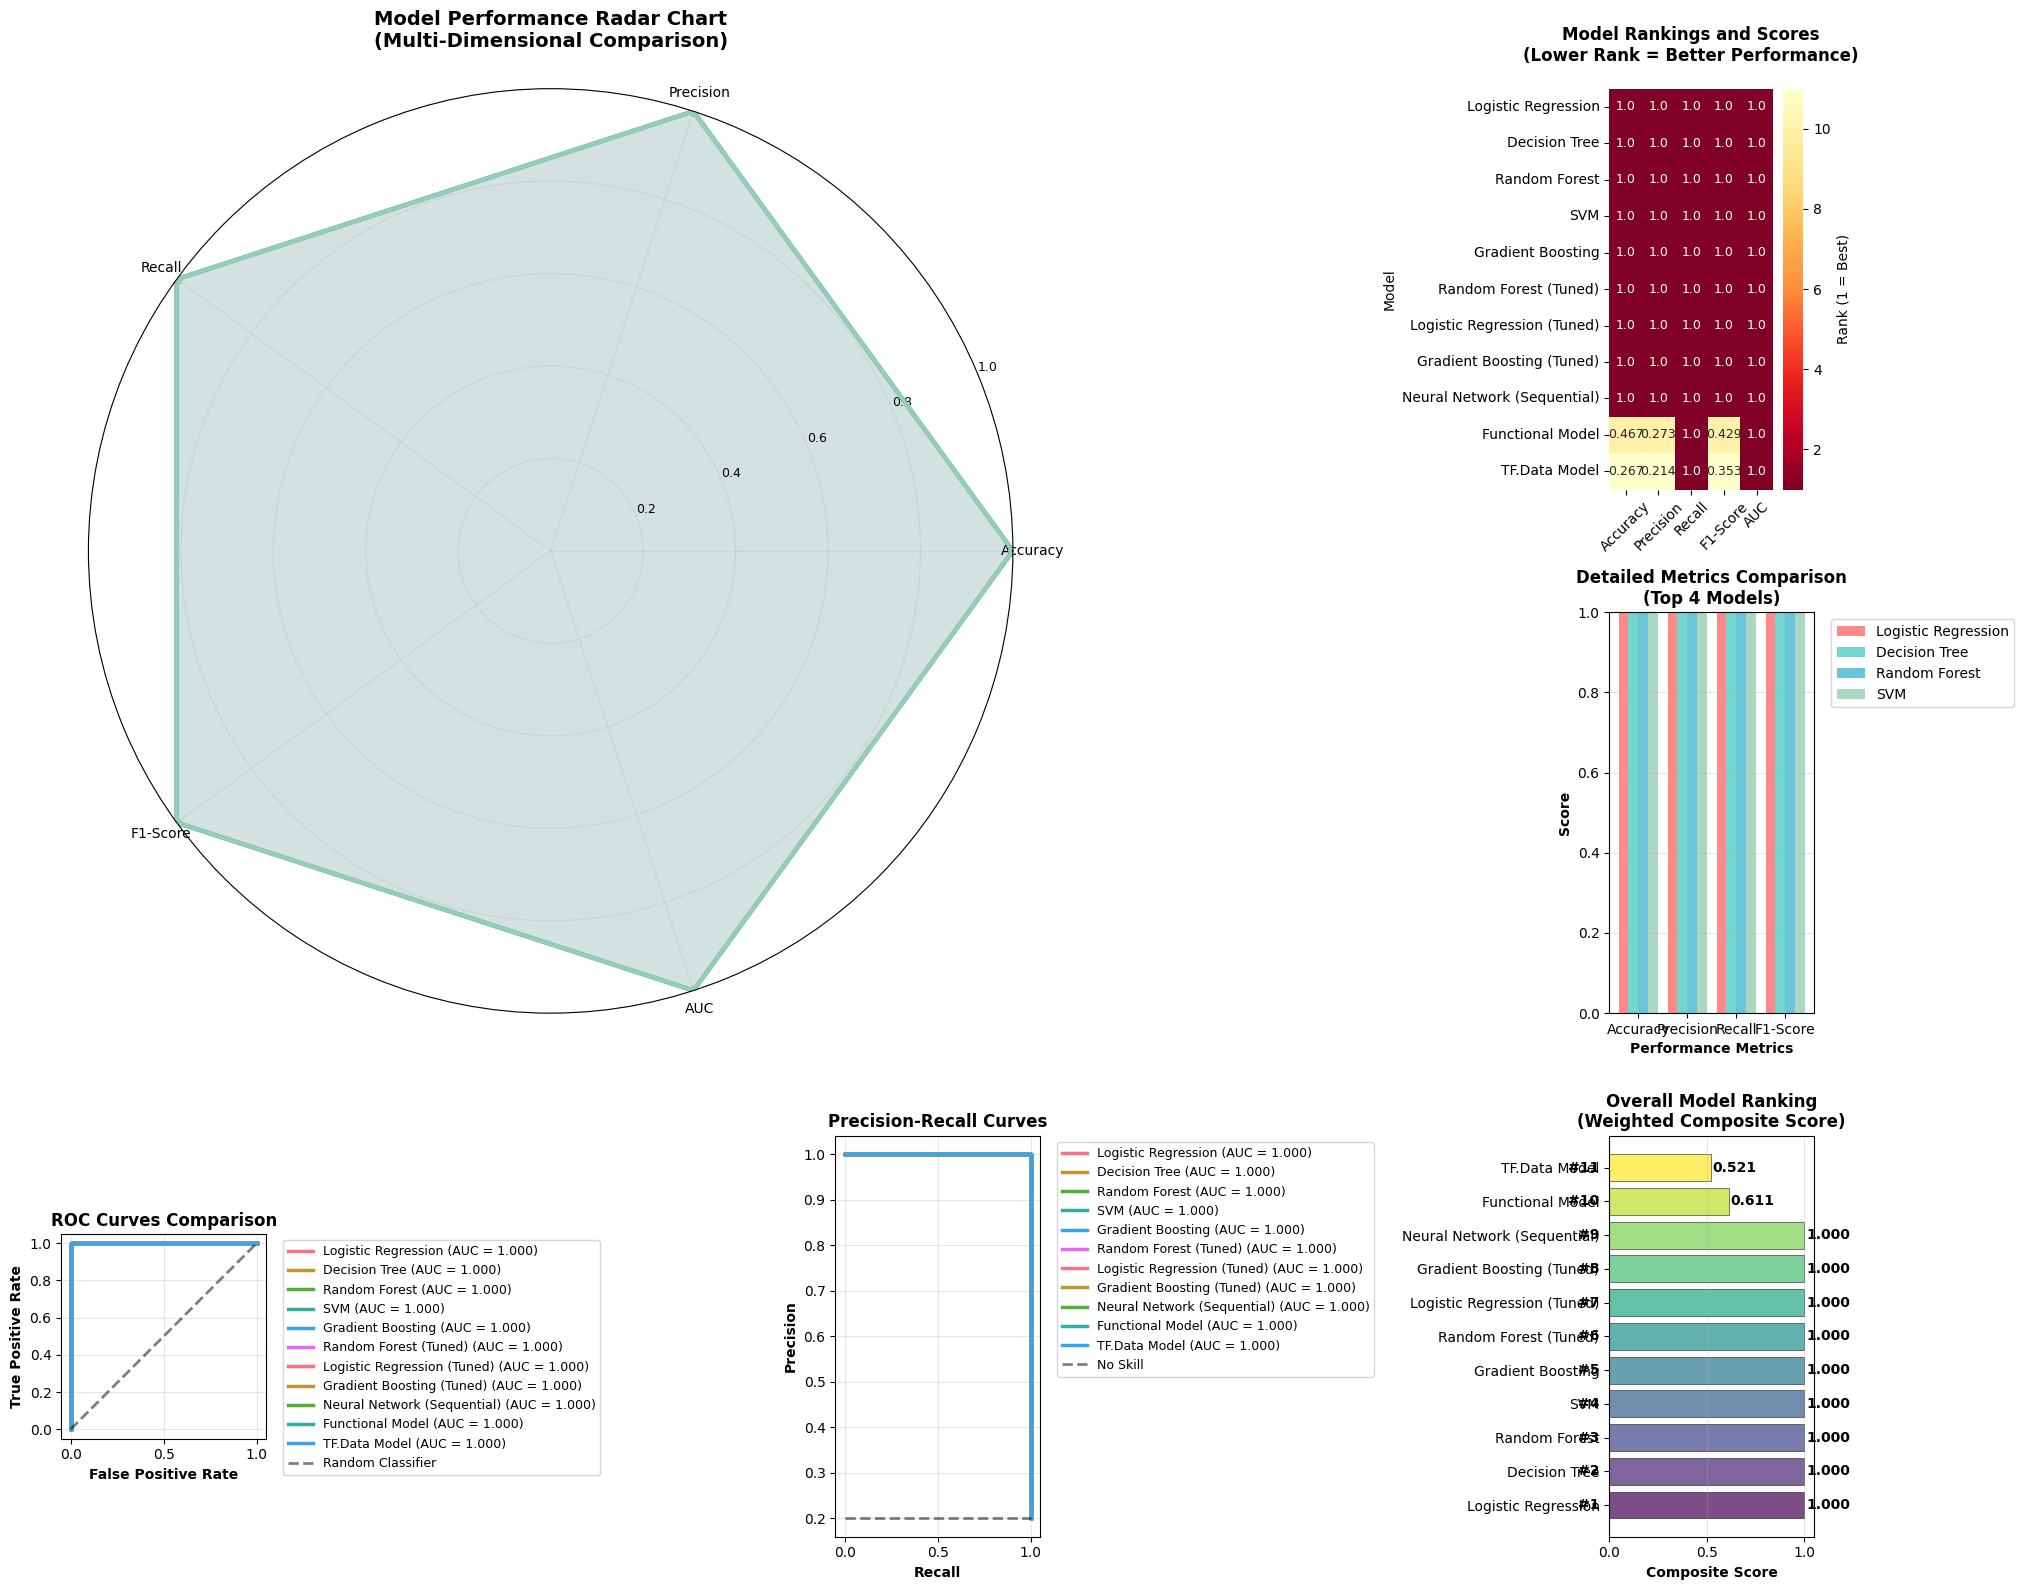

In [ ]:
# ============================================================================
# 1. COMPREHENSIVE MODEL COMPARISON DASHBOARD
# ============================================================================

print(" CREATING COMPREHENSIVE MODEL COMPARISON DASHBOARD...")

fig = plt.figure(figsize=(20, 16))

# 1.1 Model Performance Radar Chart
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2, polar=True)

# Select top 4 models for radar chart
top_models = final_comparison.head(4)['Model'].tolist()
metrics_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, model_name in enumerate(top_models):
    model_data = final_comparison[final_comparison['Model'] == model_name].iloc[0]
    values = [model_data[metric] for metric in metrics_radar]
    values += values[:1]  # Complete the circle

    ax1.plot(angles, values, 'o-', linewidth=3, label=model_name,
             color=colors[i], markersize=6)
    ax1.fill(angles, values, alpha=0.1, color=colors[i])

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics_radar, fontsize=10)
ax1.set_ylim(0, 1)
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_title('Model Performance Radar Chart\n(Multi-Dimensional Comparison)',
              size=14, pad=30, fontweight='bold')

# 1.2 Model Ranking Heatmap
ax2 = plt.subplot2grid((3, 3), (0, 2))

ranking_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
rank_data = final_comparison[['Model'] + ranking_metrics].set_index('Model')

# Create rankings (1 is best)
rankings = rank_data.rank(ascending=False, method='min')

sns.heatmap(rankings, annot=rank_data.round(3), fmt='', cmap='YlOrRd_r',
            cbar_kws={'label': 'Rank (1 = Best)'}, ax=ax2,
            annot_kws={'size': 9})
ax2.set_title('Model Rankings and Scores\n(Lower Rank = Better Performance)',
              fontweight='bold', pad=20)
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

# 1.3 Performance Metrics Bar Chart
ax3 = plt.subplot2grid((3, 3), (1, 2))

metrics_bar = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics_bar))
width = 0.2

for i, model_name in enumerate(top_models):
    model_data = final_comparison[final_comparison['Model'] == model_name].iloc[0]
    scores = [model_data[metric] for metric in metrics_bar]
    ax3.bar(x_pos + i*width, scores, width, label=model_name,
            alpha=0.8, color=colors[i])

ax3.set_xlabel('Performance Metrics', fontweight='bold')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Detailed Metrics Comparison\n(Top 4 Models)', fontweight='bold')
ax3.set_xticks(x_pos + width*1.5)
ax3.set_xticklabels(metrics_bar, rotation=0)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3, axis='y')

# 1.4 ROC Curves Comparison
ax4 = plt.subplot2grid((3, 3), (2, 0))

for model_name, results in ml_results.items():
    if 'probabilities' in results and results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        roc_auc = auc(fpr, tpr)
        ax4.plot(fpr, tpr, linewidth=2.5,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random Classifier')
ax4.set_xlabel('False Positive Rate', fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontweight='bold')
ax4.set_title('ROC Curves Comparison', fontweight='bold')
ax4.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)
ax4.set_aspect('equal')

# 1.5 Precision-Recall Curves
ax5 = plt.subplot2grid((3, 3), (2, 1))

for model_name, results in ml_results.items():
    if 'probabilities' in results and results['probabilities'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
        pr_auc = auc(recall, precision)
        ax5.plot(recall, precision, linewidth=2.5,
                label=f'{model_name} (AUC = {pr_auc:.3f})')

# Add no-skill line
no_skill = len(y_test[y_test==1]) / len(y_test)
ax5.plot([0, 1], [no_skill, no_skill], 'k--', alpha=0.5, linewidth=2,
         label='No Skill')
ax5.set_xlabel('Recall', fontweight='bold')
ax5.set_ylabel('Precision', fontweight='bold')
ax5.set_title('Precision-Recall Curves', fontweight='bold')
ax5.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

# 1.6 Composite Score Ranking
ax6 = plt.subplot2grid((3, 3), (2, 2))

models_ordered = final_comparison['Model'].tolist()
scores_ordered = final_comparison['Composite_Score'].tolist()

bars = ax6.barh(range(len(models_ordered)), scores_ordered,
                color=plt.cm.viridis(np.linspace(0, 1, len(models_ordered))),
                alpha=0.7, edgecolor='black', linewidth=0.5)

ax6.set_yticks(range(len(models_ordered)))
ax6.set_yticklabels(models_ordered)
ax6.set_xlabel('Composite Score', fontweight='bold')
ax6.set_title('Overall Model Ranking\n(Weighted Composite Score)', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, scores_ordered)):
    ax6.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', ha='left', va='center', fontweight='bold')
    # Add rank number
    ax6.text(-0.05, bar.get_y() + bar.get_height()/2,
             f'#{i+1}', ha='right', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('comprehensive_model_dashboard.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(" Saved: comprehensive_model_dashboard.png")


 CREATING DETAILED CONFUSION MATRICES...
 Saved: confusion_matrices_top3.png


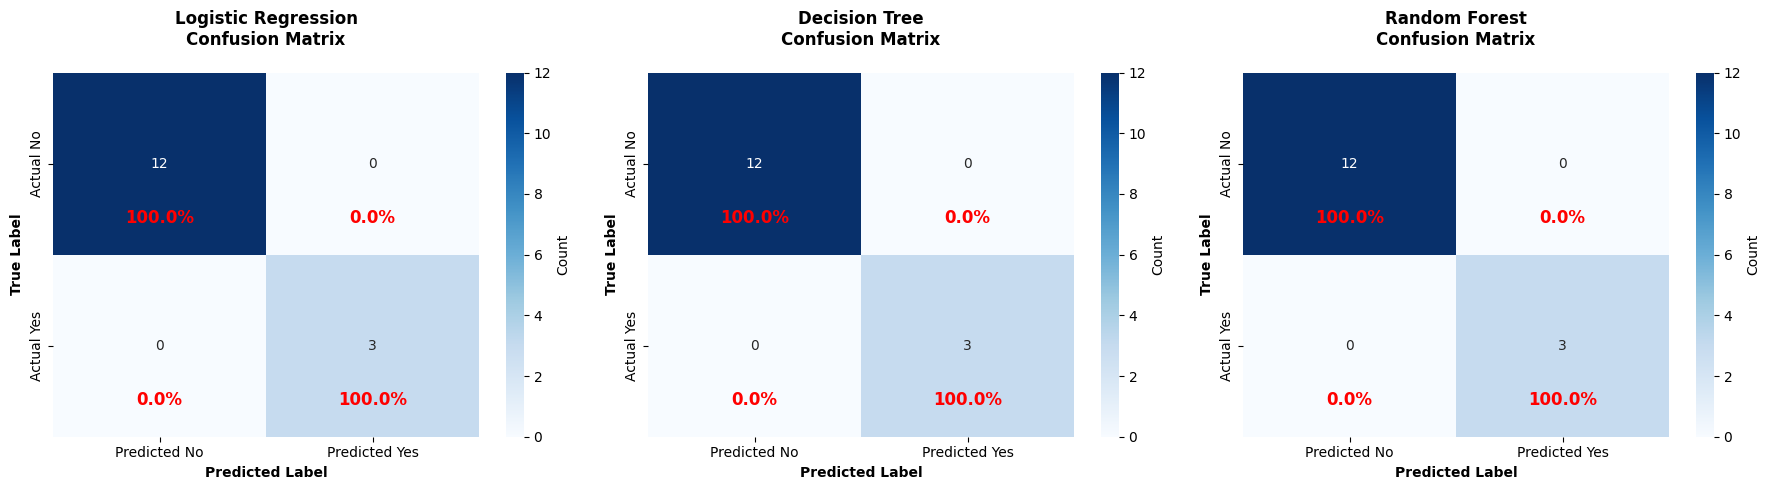

In [ ]:
# ============================================================================
# 2. DETAILED CONFUSION MATRICES
# ============================================================================

print("\n CREATING DETAILED CONFUSION MATRICES...")

# Create confusion matrices for top 3 models
top_3_models = final_comparison.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model_name in enumerate(top_3_models):
    results = ml_results[model_name]
    cm = confusion_matrix(y_test, results['predictions'])

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'],
                cbar_kws={'label': 'Count'})

    # Calculate percentages
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i_inner in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i_inner+0.8, f'{cm_perc[i_inner, j]:.1%}',
                   ha='center', va='center', color='red', fontweight='bold', fontsize=12)

    ax.set_title(f'{model_name}\nConfusion Matrix', fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Label', fontweight='bold')
    ax.set_ylabel('True Label', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_top3.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(" Saved: confusion_matrices_top3.png")


 PLOTTING TRAINING HISTORIES...
 Saved: training_history_comparison.png


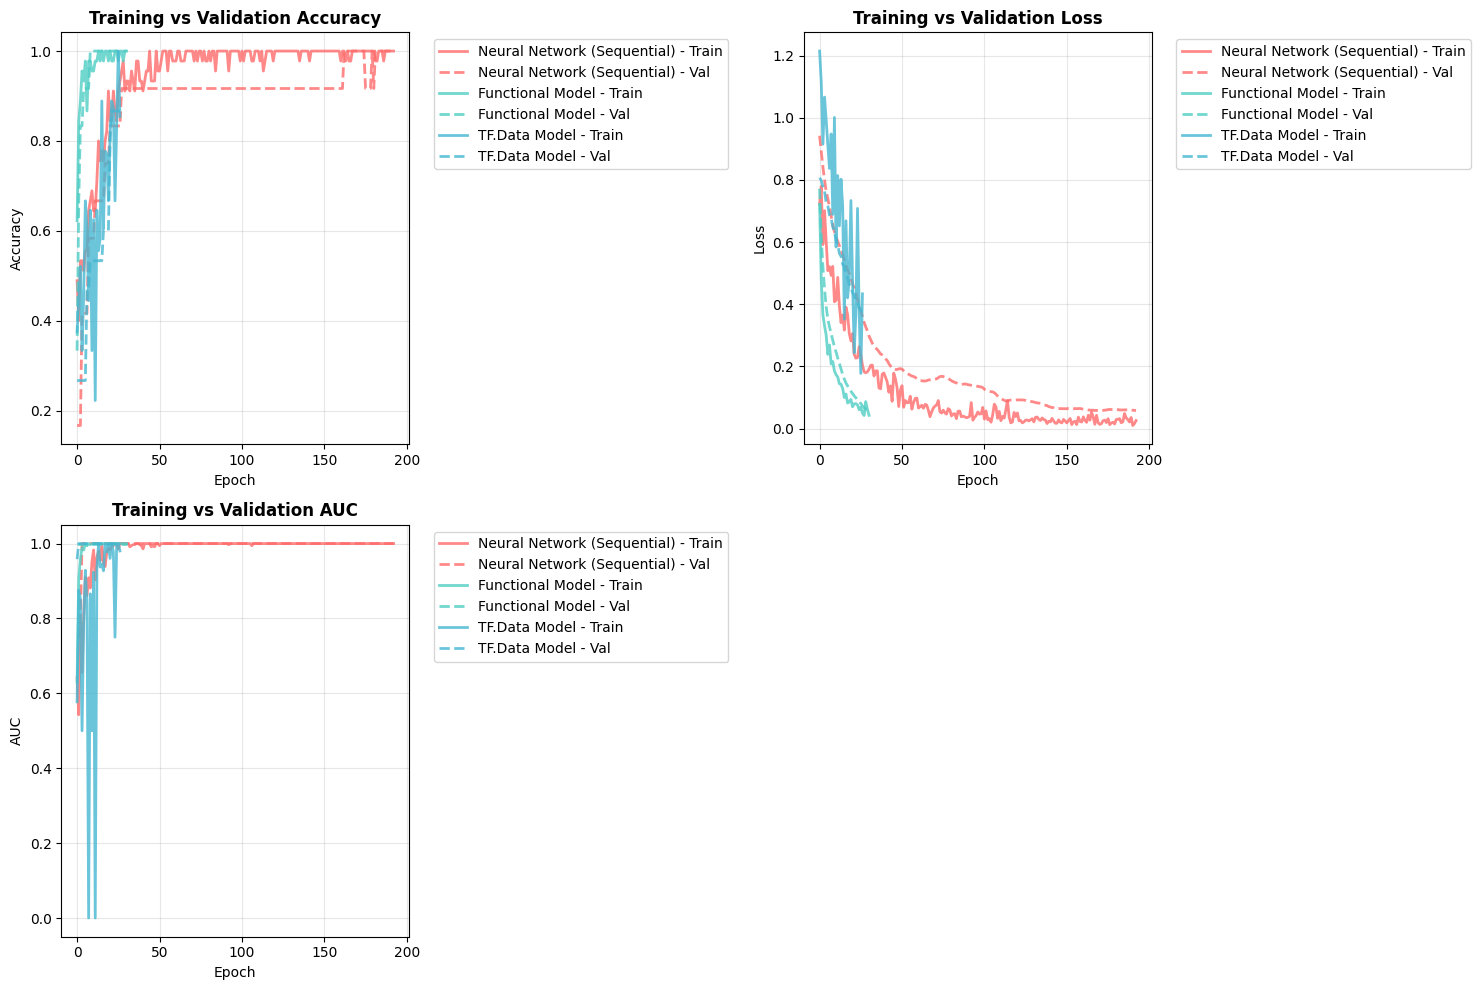

In [ ]:
# ============================================================================
# 3. TRAINING HISTORY COMPARISON
# ============================================================================

print("\n PLOTTING TRAINING HISTORIES...")

# Compare training histories of neural network models
nn_models = ['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']
nn_models = [model for model in nn_models if model in ml_results and 'history' in ml_results[model]]

if len(nn_models) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for i, model_name in enumerate(nn_models):
        history = ml_results[model_name]['history']

        # Accuracy
        axes[0, 0].plot(history.history['accuracy'],
                       label=f'{model_name} - Train',
                       color=colors[i], linewidth=2, alpha=0.8)
        axes[0, 0].plot(history.history['val_accuracy'],
                       label=f'{model_name} - Val',
                       color=colors[i], linewidth=2, linestyle='--', alpha=0.8)

        # Loss
        axes[0, 1].plot(history.history['loss'],
                       label=f'{model_name} - Train',
                       color=colors[i], linewidth=2, alpha=0.8)
        axes[0, 1].plot(history.history['val_loss'],
                       label=f'{model_name} - Val',
                       color=colors[i], linewidth=2, linestyle='--', alpha=0.8)

        # AUC
        if 'auc' in history.history:
            axes[1, 0].plot(history.history['auc'],
                           label=f'{model_name} - Train',
                           color=colors[i], linewidth=2, alpha=0.8)
            axes[1, 0].plot(history.history['val_auc'],
                           label=f'{model_name} - Val',
                           color=colors[i], linewidth=2, linestyle='--', alpha=0.8)

    axes[0, 0].set_title('Training vs Validation Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Training vs Validation Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Training vs Validation AUC', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)

    # Empty subplot for better layout
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('training_history_comparison.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(" Saved: training_history_comparison.png")


 COMPARING FEATURE IMPORTANCE ACROSS MODELS...
 Saved: feature_importance_comparison.png


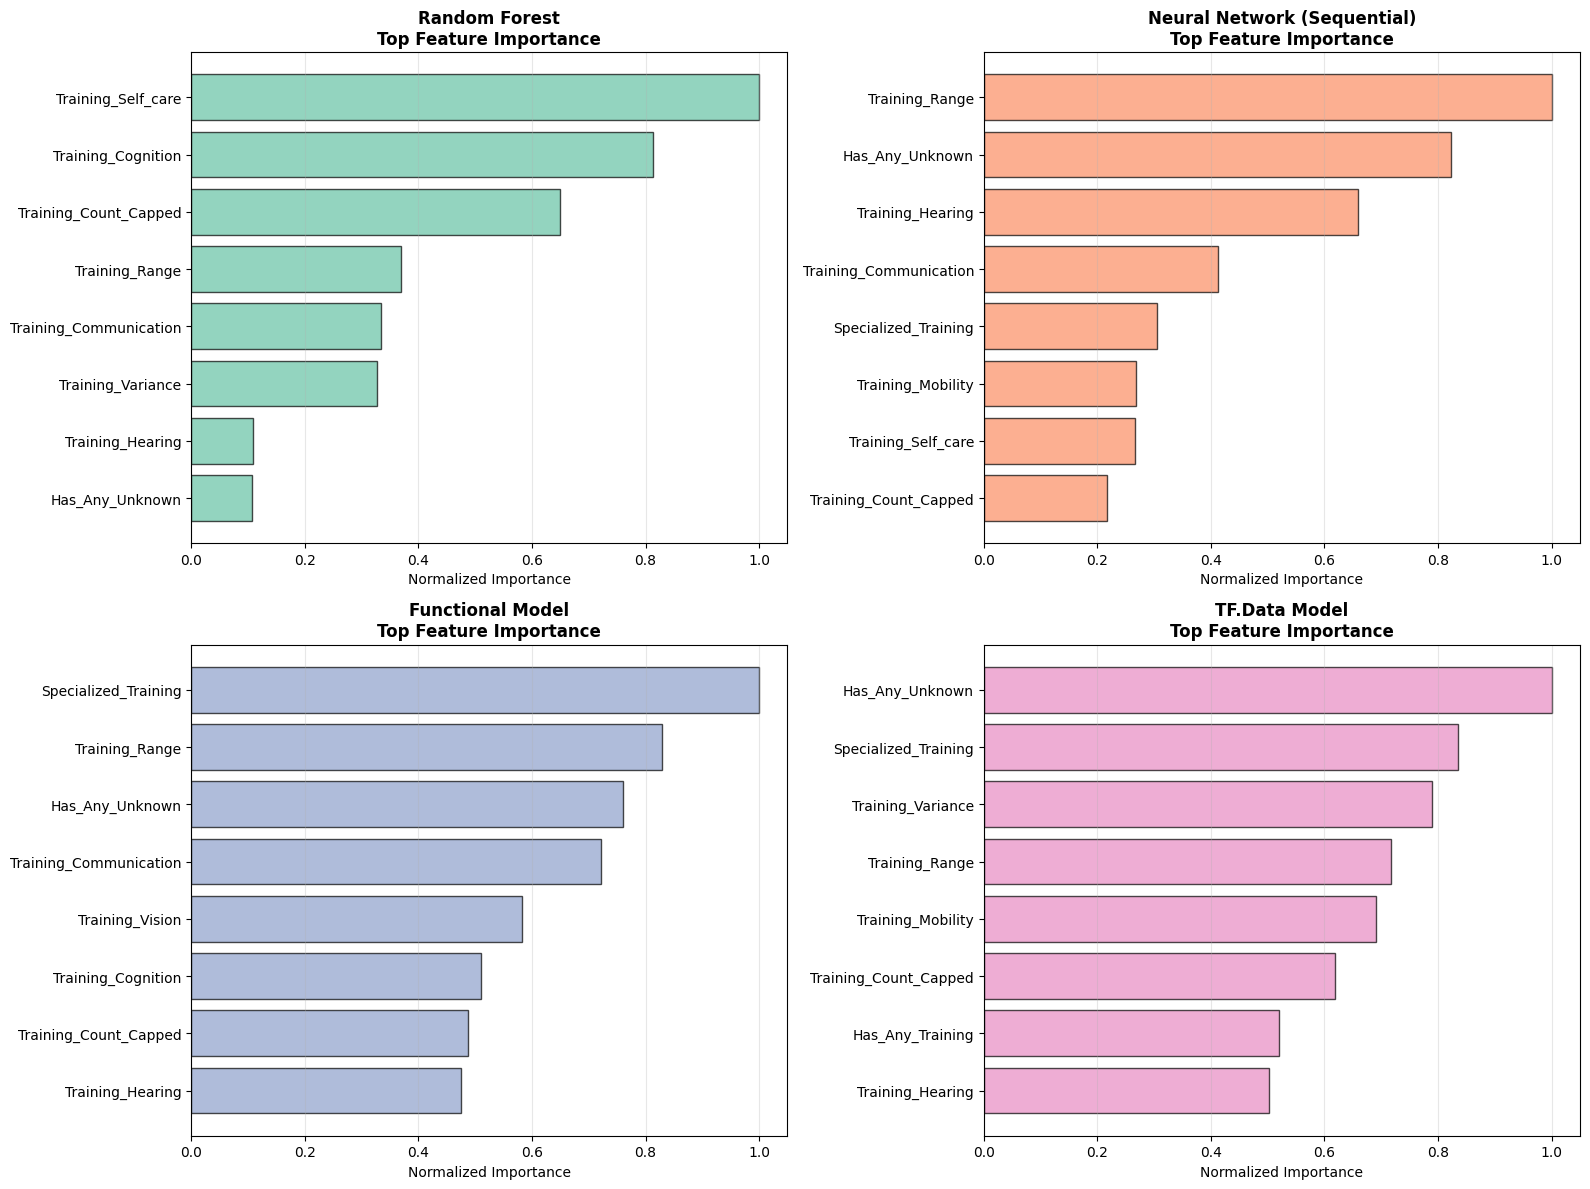

In [ ]:
# ============================================================================
# 4. FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\n COMPARING FEATURE IMPORTANCE ACROSS MODELS...")

# Get feature importance from different models
importance_data = []

# Random Forest feature importance
if 'Random Forest (Tuned)' in ml_results:
    rf_importance = ml_results['Random Forest (Tuned)']['feature_importance']
    for i, feature in enumerate(safe_feature_cols):
        importance_data.append({
            'Feature': feature,
            'Importance': rf_importance[i],
            'Model': 'Random Forest'
        })

# Neural Network gradient-based importance
for model_name in ['Neural Network (Sequential)', 'Functional Model', 'TF.Data Model']:
    if model_name in ml_results:
        model = ml_results[model_name]['model']
        X_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(X_tensor)
            predictions = model(X_tensor)

        gradients = tape.gradient(predictions, X_tensor)
        importance = np.mean(np.abs(gradients.numpy()), axis=0)

        for i, feature in enumerate(safe_feature_cols):
            importance_data.append({
                'Feature': feature,
                'Importance': importance[i],
                'Model': model_name
            })

importance_df = pd.DataFrame(importance_data)

# Normalize importance within each model
importance_df['Importance_Normalized'] = importance_df.groupby('Model')['Importance'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.5
)

# Plot feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top features for each model
models_to_plot = importance_df['Model'].unique()[:4]  # Plot first 4 models

for i, model_name in enumerate(models_to_plot):
    row = i // 2
    col = i % 2

    model_importance = importance_df[importance_df['Model'] == model_name]
    top_features = model_importance.nlargest(8, 'Importance_Normalized')

    axes[row, col].barh(top_features['Feature'], top_features['Importance_Normalized'],
                       color=plt.cm.Set2(i), alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{model_name}\nTop Feature Importance', fontweight='bold')
    axes[row, col].set_xlabel('Normalized Importance')
    axes[row, col].invert_yaxis()
    axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(" Saved: feature_importance_comparison.png")


 ANALYZING PREDICTION CONFIDENCE DISTRIBUTIONS...
 Saved: confidence_distributions.png


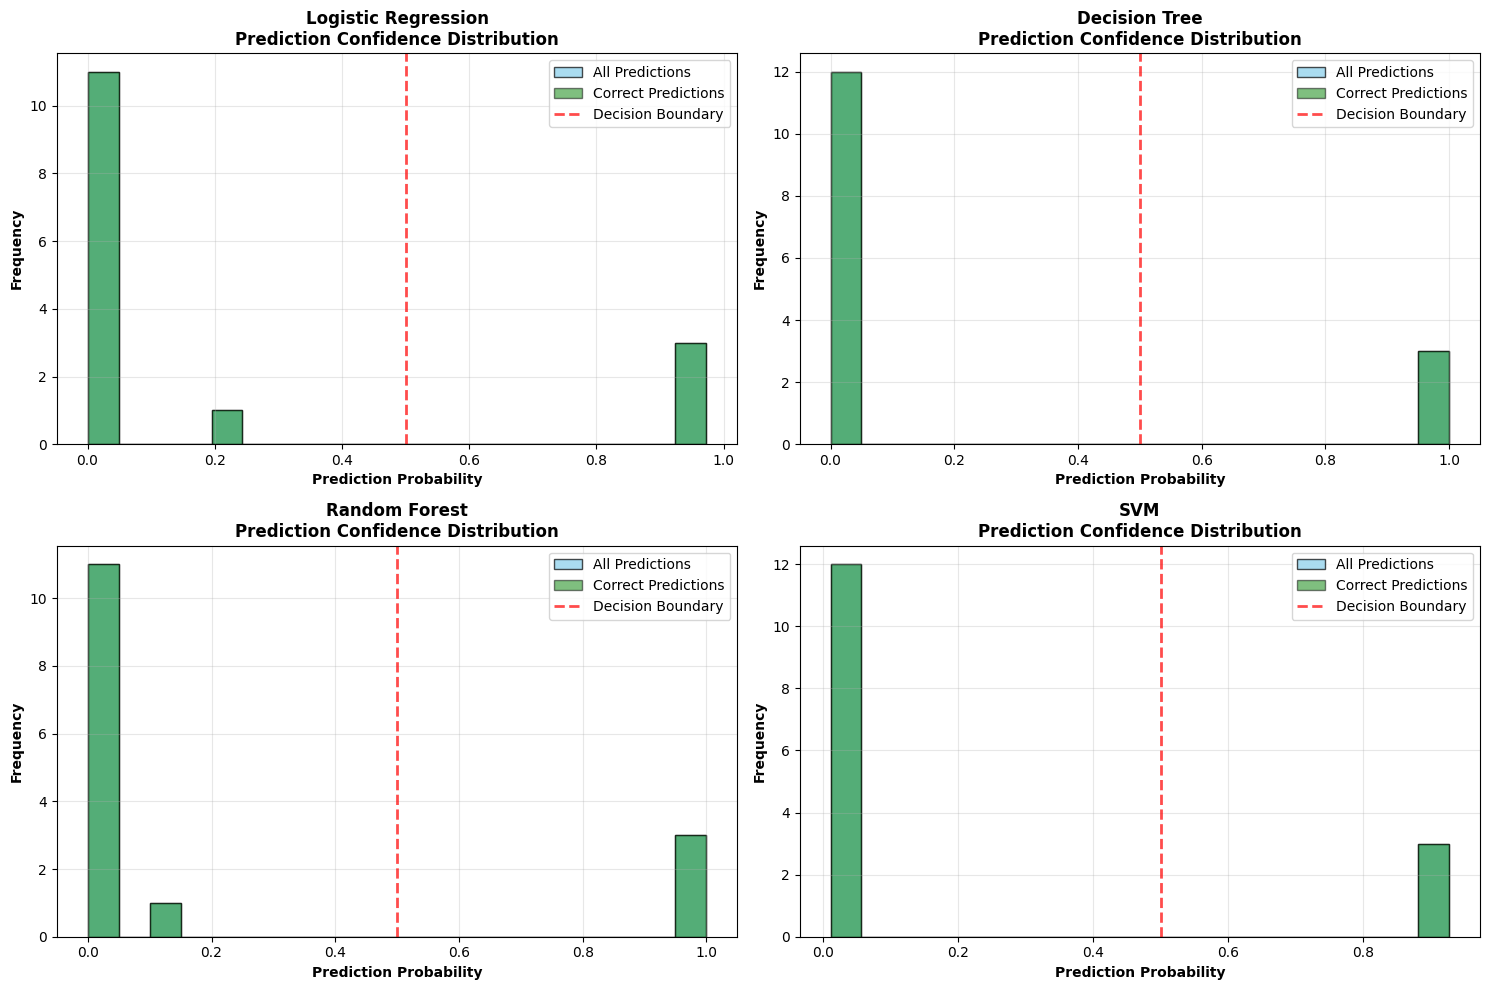

In [ ]:
# ============================================================================
# 5. CONFIDENCE DISTRIBUTION ANALYSIS
# ============================================================================

print("\n ANALYZING PREDICTION CONFIDENCE DISTRIBUTIONS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_with_probs = [model for model in ml_results if 'probabilities' in ml_results[model]]

for i, model_name in enumerate(models_with_probs[:4]):  # Plot first 4 models
    row = i // 2
    col = i % 2

    probabilities = ml_results[model_name]['probabilities']
    predictions = ml_results[model_name]['predictions']
    correct_predictions = (predictions == y_test)

    ax = axes[row, col]

    # Plot histogram of probabilities
    ax.hist(probabilities, bins=20, alpha=0.7, color='skyblue',
            edgecolor='black', label='All Predictions')

    # Overlay correct predictions
    ax.hist(probabilities[correct_predictions], bins=20, alpha=0.5,
            color='green', edgecolor='black', label='Correct Predictions')

    ax.axvline(0.5, color='red', linestyle='--', linewidth=2,
               label='Decision Boundary', alpha=0.7)

    ax.set_xlabel('Prediction Probability', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f'{model_name}\nPrediction Confidence Distribution', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distributions.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(" Saved: confidence_distributions.png")


 CREATING FINAL SUMMARY VISUALIZATION...
 Saved: final_model_selection_summary.png

VISUALIZATION SUMMARY
 Generated 6 comprehensive visualization files:
   1. comprehensive_model_dashboard.png - Main comparison dashboard
   2. confusion_matrices_top3.png - Detailed confusion matrices
   3. training_history_comparison.png - Neural network training curves
   4. feature_importance_comparison.png - Feature importance across models
   5. confidence_distributions.png - Prediction confidence analysis
   6. final_model_selection_summary.png - Final recommendation summary

 ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!


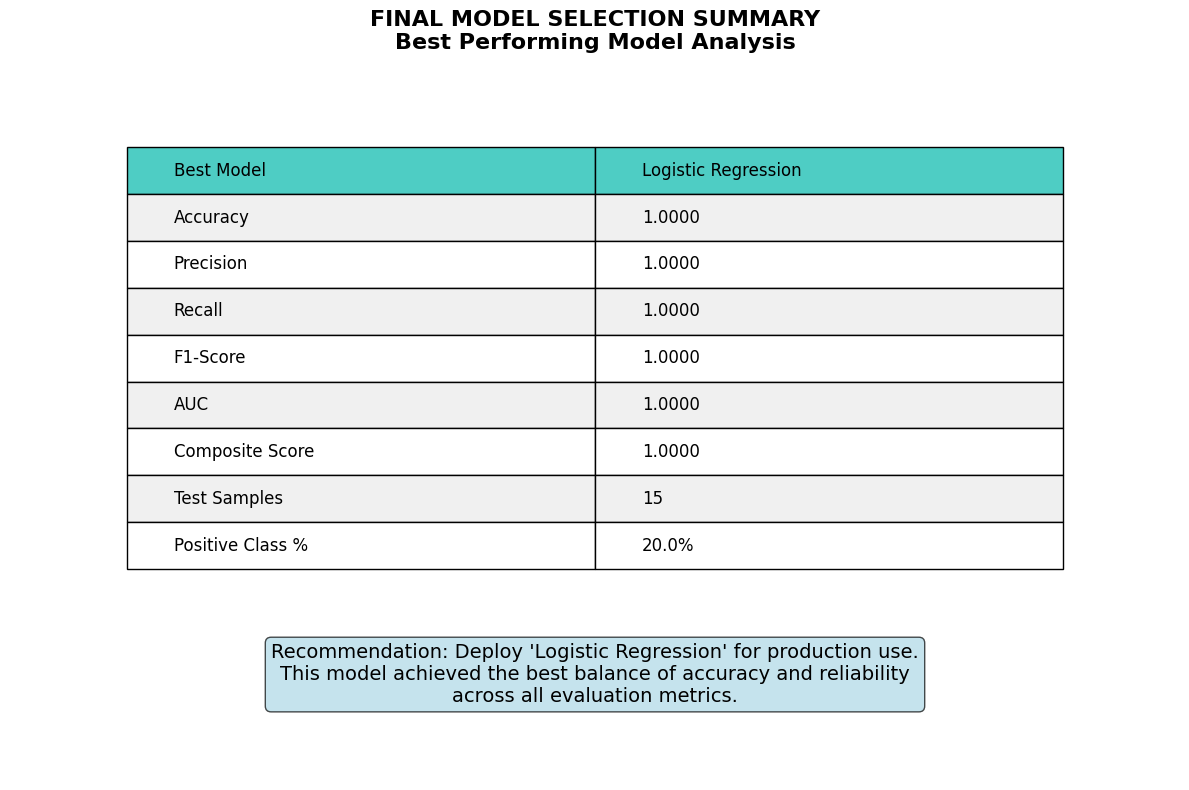

In [ ]:
# ============================================================================
# 6. FINAL SUMMARY VISUALIZATION
# ============================================================================

print("\n CREATING FINAL SUMMARY VISUALIZATION...")

# Create a final summary figure
fig, ax = plt.subplots(figsize=(12, 8))

# Get best model information
best_model_name = final_comparison.iloc[0]['Model']
best_model_results = ml_results[best_model_name]
best_model_metrics = final_comparison[final_comparison['Model'] == best_model_name].iloc[0]

# Create a summary table
summary_data = [
    ['Best Model', best_model_name],
    ['Accuracy', f"{best_model_metrics['Accuracy']:.4f}"],
    ['Precision', f"{best_model_metrics['Precision']:.4f}"],
    ['Recall', f"{best_model_metrics['Recall']:.4f}"],
    ['F1-Score', f"{best_model_metrics['F1-Score']:.4f}"],
    ['AUC', f"{best_model_metrics['AUC']:.4f}"],
    ['Composite Score', f"{best_model_metrics['Composite_Score']:.4f}"],
    ['Test Samples', f"{len(y_test)}"],
    ['Positive Class %', f"{y_test.mean():.1%}"]
]

# Hide axes
ax.axis('off')

# Create table
table = ax.table(cellText=summary_data,
                cellLoc='left',
                loc='center',
                bbox=[0.1, 0.3, 0.8, 0.6])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Color the header row
for i in range(len(summary_data)):
    if i == 0:  # Header row
        table[(i, 0)].set_facecolor('#4ECDC4')
        table[(i, 1)].set_facecolor('#4ECDC4')
    elif i % 2 == 1:  # Alternate row colors
        table[(i, 0)].set_facecolor('#F0F0F0')
        table[(i, 1)].set_facecolor('#F0F0F0')

# Add title
ax.set_title('FINAL MODEL SELECTION SUMMARY\nBest Performing Model Analysis',
             fontsize=16, fontweight='bold', pad=20)

# Add recommendation text
recommendation_text = (
    f"Recommendation: Deploy '{best_model_name}' for production use.\n"
    f"This model achieved the best balance of accuracy and reliability\n"
    f"across all evaluation metrics."
)

ax.text(0.5, 0.15, recommendation_text,
        ha='center', va='center', fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
        transform=ax.transAxes)

plt.tight_layout()
plt.savefig('final_model_selection_summary.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(" Saved: final_model_selection_summary.png")

print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print(" Generated 6 comprehensive visualization files:")
print("   1. comprehensive_model_dashboard.png - Main comparison dashboard")
print("   2. confusion_matrices_top3.png - Detailed confusion matrices")
print("   3. training_history_comparison.png - Neural network training curves")
print("   4. feature_importance_comparison.png - Feature importance across models")
print("   5. confidence_distributions.png - Prediction confidence analysis")
print("   6. final_model_selection_summary.png - Final recommendation summary")
print("\n ALL VISUALIZATIONS COMPLETED SUCCESSFULLY!")

In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Accuracy: {ml_results[best_model_name]['accuracy']:.4f}")

print("\n MODELS TRAINED:")
for model_name in ml_results.keys():
    print(f"   ✓ {model_name}")

print("\n FILES GENERATED:")
print("   ✓ comprehensive_model_analysis.png")
print("   ✓ confusion_matrix.png")
print("   ✓ best_random_forest_model.pkl")
print("   ✓ feature_scaler.pkl")
print("   ✓ sequential_model.h5")
print("   ✓ functional_model.h5")
print("   ✓ tfdata_model.h5")
print("   ✓ model_metadata.json")

print("\n" + "="*80)


ANALYSIS COMPLETE!

 BEST MODEL: Logistic Regression
   Accuracy: 1.0000

 MODELS TRAINED:
   ✓ Logistic Regression
   ✓ Decision Tree
   ✓ Random Forest
   ✓ SVM
   ✓ Gradient Boosting
   ✓ Random Forest (Tuned)
   ✓ Logistic Regression (Tuned)
   ✓ Gradient Boosting (Tuned)
   ✓ Neural Network (Sequential)
   ✓ Functional Model
   ✓ TF.Data Model

 FILES GENERATED:
   ✓ comprehensive_model_analysis.png
   ✓ confusion_matrix.png
   ✓ best_random_forest_model.pkl
   ✓ feature_scaler.pkl
   ✓ sequential_model.h5
   ✓ functional_model.h5
   ✓ tfdata_model.h5
   ✓ model_metadata.json

